Next steps

1.   Read in data
2. Learn more about recommender systems (BY THURSDAY 11/7)
  *   Collaborative filtering
  * Read Kaggle projects tagged 'reccomender systems'
3.   Exploratory (BY MONDAY 11/11)
    * Merging datasets 
    * Basic frequencies (Projects, Donors, Donors per project, Projects per donor, biggest geographical areas (State))
    *  Missing Data
4.   Generate negative instances (11/15)
5.   Modeling (BY 11/20)
6.   Essay component if time
 



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! pip install pgeocode

In [0]:
! pip install uszipcode

     |████████████████████████████████| 378kB 4.8MB/s 
     |████████████████████████████████| 204kB 46.1MB/s 
     |████████████████████████████████| 122kB 43.5MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for autopep8: filename=autopep8-1.4.4-py2.py3-none-any.whl size=42631 sha256=ca3a71ba83217d06492d726c08a36f476c77ba16999dfbe74dd32e9b09dd6a5e
  Stored in directory: /root/.cache/pip/wheels/7e/f5/4b/c19e6276126325eb8071b273347c05a830c37a82b9b3b81510
Successfully built autopep8


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # create graphs
from pandas.plotting import parallel_coordinates # for parallel coordinate plot
from datetime import datetime # convert string to date
import math # for extra math functions

from sklearn.model_selection import train_test_split # For splitting data into train and test sets for the prediction model
from sklearn.metrics import confusion_matrix # Confusion matrix for assessing model at the end
#from sklearn.ensemble import RandomForestClassifier # For creating a random forest classifier model
from xgboost import XGBClassifier # For XGBoost classifier model

import gc # for garbage collection to reduce RAM load

import pgeocode

In [0]:
# Columns for donors
DonorCols = ['Donor ID', 'Donor City', 'Donor State', 'Donor Is Teacher','Donor Zip']

# Columns for projects
ProjectCols = ['Project ID', 'School ID', 'Teacher ID', 'Teacher Project Posted Sequence', 'Project Type',
               'Project Subject Category Tree', 'Project Subject Subcategory Tree', 'Project Grade Level Category', 'Project Resource Category', 'Project Cost', 
               'Project Posted Date', 'Project Expiration Date', 'Project Fully Funded Date']

# Columns for schools
SchoolCols = ['School ID', 'School Metro Type', 'School Percentage Free Lunch', 'School State', 'School City', 'School Zip', 'School District', 'School County']

# Columns for resources
ResourceCols = ['Project ID', 'Resource Quantity', 'Resource Unit Price']

In [0]:
# Load data
donations = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Donations.csv', parse_dates=['Donation Received Date'])
donors = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Donors.csv', usecols=DonorCols, dtype={'Donor Zip': 'str'})
projects = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projects.csv', usecols=ProjectCols, parse_dates=['Project Posted Date', 'Project Expiration Date', 'Project Fully Funded Date'])
resources = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Resources.csv', usecols=ResourceCols)
schools = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Schools.csv', usecols=SchoolCols)
teachers = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Teachers.csv', parse_dates=['Teacher First Project Posted Date'])

print('Data loaded')


Data loaded


In [0]:
schools['School Zip']=schools['School Zip'].astype(str)
#take the first 3 numbers of the school zip only, and add '00' to the end, so that the school
#zip codes represent the same as the donor zips
schools['School Zip'] = schools['School Zip'].str[:3]+'01'
schools.isnull().sum(axis = 0)
#try to predict city from the zip and comput mean for the percentage free lunch

School ID                          0
School Metro Type                  0
School Percentage Free Lunch    1141
School State                       0
School Zip                         0
School City                      227
School County                      2
School District                    0
dtype: int64

In [0]:
from uszipcode.search import SearchEngine
search = SearchEngine()
zipcode = search.by_zipcode("10001")
print(zipcode)

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!
SimpleZipcode(zipcode='10001', zipcode_type='Standard', major_city='New York', post_office_city='New York, NY', common_city_list=['New York'], county='New York County', state='NY', lat=40.75, lng=-73.99, timezone='Eastern', radius_in_miles=0.9090909090909091, area_code_list=['718', '917', '347', '646'], population=21102, population_density=33959.0, land_area_in_sqmi=0.62, water_area_in_sqmi=0.0, housing_units=12476, occupied_housing_units=11031, median_home_value=650200, median_household_income=81671, bounds_west=-74.008621, bounds_east=-73.984076, bounds_north=40.759731, bounds_south=40.743451)


In [0]:
#imputung the missing city from the zipcode
count=0
from uszipcode.search import SearchEngine
search = SearchEngine()
ls=list(schools['School City'])
for index,row in schools.iterrows():
  if pd.isnull(row['School City']):
    if pd.isnull(row['School Zip']):
      ls.append(row['School City'])
    else:
      zipcode = search.by_zipcode(row['School Zip'])
      #print(zipcode)
      row['School City']=zipcode.major_city
      #print(row['City'])
      ls[index]=row['School City']
schools['School City']=ls
print(count)

0


In [0]:
#imputung the missing city from the zipcode
count=0
from uszipcode.search import SearchEngine
search = SearchEngine()
ls=list(schools['School County'])
for index,row in schools.iterrows():
  if pd.isnull(row['School County']):
    if pd.isnull(row['School Zip']):
      ls.append(row['School County'])
    else:
      zipcode = search.by_zipcode(row['School Zip'])
      #print(zipcode)
      row['School County']=zipcode.county
      #print(row['City'])
      ls[index]=row['School County']
schools['School County']=ls
print(count)

0


In [0]:
schools['School Percentage Free Lunch'].fillna((schools['School Percentage Free Lunch'].mean()),inplace=True)

In [0]:
schools.dropna(inplace=True)

In [0]:
schools.isnull().sum(axis = 0)

School ID                       0
School Metro Type               0
School Percentage Free Lunch    0
School State                    0
School Zip                      0
School City                     0
School County                   0
School District                 0
dtype: int64

In [0]:
schools.to_csv('schools_clean.csv')
!cp schools_clean.csv drive/My\ Drive/

In [0]:
schools_clean = pd.read_csv('/content/drive/My Drive/Colab Notebooks/schools_clean.csv', usecols=SchoolCols)
schools_clean.isnull().sum(axis = 0)

School ID                       0
School Metro Type               0
School Percentage Free Lunch    0
School State                    0
School Zip                      0
School City                     0
School County                   0
School District                 0
dtype: int64

In [0]:
donations.isnull().sum(axis = 0)


Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
dtype: int64

In [0]:
donations.to_csv('donations_clean.csv')
!cp donations_clean.csv drive/My\ Drive/

In [0]:

donors = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Donors.csv', usecols=DonorCols, dtype={'Donor Zip': 'str'})

In [0]:
donors.isnull().sum(axis = 0)
#try to get city from the zip or zip from the city

Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64

In [0]:
#dataframes of donor and school zip codes with donation ID
#remove null values for donor and school zips
#make all zip codes strings
#donors['Donor Zip']=donors['Donor Zip'].astype(str)

#since we only have the first three characters of donor's zip code, add '00' to the end of each
#this way, each zip code represents the locatopm of the central post office facility 
#donors['Donor Zip'] = donors['Donor Zip']+'01'
zipd=list(donors['Donor Zip'])
for index,row in donors.iterrows():
  if pd.notnull(row['Donor Zip']):
    zipd[index]=row['Donor Zip']+'01'
  else:
    zipd[index]=row['Donor Zip']



donors['Donor Zip']=zipd

In [0]:
donors.isnull().sum(axis = 0)

Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64

In [0]:
count=0
from uszipcode.search import SearchEngine
search = SearchEngine()
lsd=list(donors['Donor City'])
for index,row in donors.iterrows():
  if pd.isnull(row['Donor City']):
    if pd.isnull(row['Donor Zip']):
      continue
    else:
      zipcode = search.by_zipcode(row['Donor Zip'])
      #print(zipcode)
      row['Donor City']=zipcode.major_city
      #print(row['City'])
      lsd[index]=row['Donor City']
donors['Donor City']=lsd
print(count)

0


In [0]:
donors.dropna(inplace=True)

In [0]:
donors.isnull().sum(axis = 0)

Donor ID            0
Donor City          0
Donor State         0
Donor Is Teacher    0
Donor Zip           0
dtype: int64

In [0]:
donors.to_csv('donors_clean.csv')
!cp donors_clean.csv drive/My\ Drive/

In [0]:
projects.isnull().sum(axis = 0)
#drop rows with missing project resourceces, subject categpry and subcategory

Project ID                               0
School ID                                0
Teacher ID                               0
Teacher Project Posted Sequence          0
Project Type                             0
Project Subject Category Tree           29
Project Subject Subcategory Tree        29
Project Grade Level Category             0
Project Resource Category               36
Project Cost                             0
Project Posted Date                      0
Project Expiration Date                 14
Project Fully Funded Date           283253
dtype: int64

In [0]:
projects.dropna(subset=['Project Subject Category Tree','Project Subject Subcategory Tree','Project Resource Category'],inplace=True)

In [0]:
projects.isnull().sum(axis = 0)

Project ID                               0
School ID                                0
Teacher ID                               0
Teacher Project Posted Sequence          0
Project Type                             0
Project Subject Category Tree            0
Project Subject Subcategory Tree         0
Project Grade Level Category             0
Project Resource Category                0
Project Cost                             0
Project Posted Date                      0
Project Expiration Date                 14
Project Fully Funded Date           283242
dtype: int64

In [0]:
projects.to_csv('projects_clean.csv')
!cp projects_clean.csv drive/My\ Drive/

In [0]:
resources.isnull().sum(axis = 0)
#replace with mean value quantity and uniut price 

Project ID                 0
Resource Quantity      24299
Resource Unit Price    24310
dtype: int64

In [0]:
resources['Resource Quantity'].fillna((resources['Resource Quantity'].mean()),inplace=True)
resources['Resource Unit Price'].fillna((resources['Resource Unit Price'].mean()),inplace=True)

In [0]:
resources.isnull().sum(axis = 0)

Project ID             0
Resource Quantity      0
Resource Unit Price    0
dtype: int64

In [0]:
resources.to_csv('resources_clean.csv')
!cp resources_clean.csv drive/My\ Drive/

In [0]:
teachers.isnull().sum(axis = 0)
#represented using other category

Teacher ID                            0
Teacher Prefix                       28
Teacher First Project Posted Date     0
dtype: int64

In [0]:
teachers.to_csv('teachers_clean.csv')
!cp teachers_clean.csv drive/My\ Drive/

In [0]:
q=projects['Project Fully Funded Date'].quantile(0.8)
print(q)
q1=projects['Project Expiration Date'].quantile(0.76)
print(q1)
q2=projects['Project Posted Date'].quantile(0.8)
print(q2)

2017-10-18 00:00:00
2017-12-06 00:00:00
2017-09-14 00:00:00


In [0]:
# Select parameters for creating the subset later
Date = '2017-09-01' #Default 2018-01-01
SubsetNumDonors = 3000 #Maximum subset size, default 1000
SubsetNumProj = 3000 #Maximum subset size, default 1000
RndSeed = 404 #Default 404
MinDonations = 5 #Default 5
print('Date: ' + Date)
print('Subset number of donors: ' + str(SubsetNumDonors))
print('Subset number of projects live at chosen date: ' + str(SubsetNumProj))
print('Random seed value for sampling subset: ' + str(RndSeed))
print('Minimum number of donations for inclusion in training: ' + str(MinDonations))

Date: 2018-01-01
Subset number of donors: 3000
Subset number of projects live at chosen date: 3000
Random seed value for sampling subset: 404
Minimum number of donations for inclusion in training: 5


In [0]:
# Process subject category
ProjCat = projects[['Project ID', 'Project Subject Category Tree']]
ProjCat['Project Subject Category Tree'] = ProjCat['Project Subject Category Tree'].str.replace(', ', '--')
ProjCat['Project Subject Category Tree'] = ProjCat['Project Subject Category Tree'].str.replace('h--', 'h, ')
ProjCat.loc[:, 'Cat_Pri'],ProjCat.loc[:, 'Cat_Sec'] = ProjCat['Project Subject Category Tree'].str.split('--').str

#idx_contains_warmth = ProjCat['Project Subject Category Tree'].str.contains('Warmth', na=False)
#ProjCat[idx_contains_warmth].head()
ProjCat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,Project ID,Project Subject Category Tree,Cat_Pri,Cat_Sec
0,7685f0265a19d7b52a470ee4bac883ba,Applied Learning,Applied Learning,NaN
1,f9f4af7099061fb4bf44642a03e5c331,Applied Learning--Literacy & Language,Applied Learning,Literacy & Language
2,afd99a01739ad5557b51b1ba0174e832,Literacy & Language,Literacy & Language,NaN
3,c614a38bb1a5e68e2ae6ad9d94bb2492,Literacy & Language,Literacy & Language,NaN
4,ec82a697fab916c0db0cdad746338df9,Special Needs,Special Needs,NaN


In [0]:

ProjSubcat = projects[['Project ID', 'Project Subject Subcategory Tree']]
ProjSubcat['Project Subject Subcategory Tree'] = ProjSubcat['Project Subject Subcategory Tree'].str.replace(', ', '--')
ProjSubcat['Project Subject Subcategory Tree'] = ProjSubcat['Project Subject Subcategory Tree'].str.replace('h--', 'h, ')
ProjSubcat.loc[:, 'Subcat_Pri'],ProjSubcat.loc[:, 'Subcat_Sec'] = ProjSubcat['Project Subject Subcategory Tree'].str.split('--').str

ProjSubcat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,Project ID,Project Subject Subcategory Tree,Subcat_Pri,Subcat_Sec
0,7685f0265a19d7b52a470ee4bac883ba,Character Education--Early Development,Character Education,Early Development
1,f9f4af7099061fb4bf44642a03e5c331,Early Development--Literacy,Early Development,Literacy
2,afd99a01739ad5557b51b1ba0174e832,ESL,ESL,NaN
3,c614a38bb1a5e68e2ae6ad9d94bb2492,ESL--Literacy,ESL,Literacy
4,ec82a697fab916c0db0cdad746338df9,Special Needs,Special Needs,NaN


In [0]:
#Replace the category and subcategory columns with the new split columns
Projects_adj = (projects.merge(ProjCat.drop(columns=['Project Subject Category Tree']), on='Project ID', how='inner')
                .merge(ProjSubcat.drop(columns=['Project Subject Subcategory Tree']), on='Project ID', how='inner')
               .drop(columns=['Project Subject Category Tree'])
               .drop(columns=['Project Subject Subcategory Tree']))

del projects
gc.collect()
Projects_adj.head()

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Fully Funded Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,2013-01-11,Applied Learning,NaN,Character Education,Early Development
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,NaT,Applied Learning,Literacy & Language,Early Development,Literacy
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,2013-05-22,Literacy & Language,NaN,ESL,NaN
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,Teacher-Led,Grades 3-5,Books,161.26,2013-01-01,2013-05-31,2013-02-06,Literacy & Language,NaN,ESL,Literacy
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,Teacher-Led,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,2013-01-01,Special Needs,NaN,Special Needs,NaN


In [0]:
#Filter projects by date
print('Date: ' + Date)

# Seed value for random subset selection = 404
Projects_t = Projects_adj[(Projects_adj['Project Fully Funded Date'] < Date) | (Projects_adj['Project Expiration Date'] < Date)]
Projects_t.head()

Date: 2018-01-01


,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Fully Funded Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,Teacher-Led,Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,2013-01-11,Applied Learning,NaN,Character Education,Early Development
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,Teacher-Led,Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,NaT,Applied Learning,Literacy & Language,Early Development,Literacy
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,Teacher-Led,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,2013-05-22,Literacy & Language,NaN,ESL,NaN
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,Teacher-Led,Grades 3-5,Books,161.26,2013-01-01,2013-05-31,2013-02-06,Literacy & Language,NaN,ESL,Literacy
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,Teacher-Led,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,2013-01-01,Special Needs,NaN,Special Needs,NaN


In [0]:
print('Subset number of projects live at chosen date: ' + str(SubsetNumProj))
print('Random seed value for sampling subset: ' + str(RndSeed))

#Find live projects at reference date
LiveProjects_tmp = (Projects_adj[(Projects_adj['Project Posted Date'] <= Date) & 
                                ((Projects_adj['Project Fully Funded Date'] >= Date) | (Projects_adj['Project Expiration Date'] >= Date))]
                   )

print("Total number of live projects: {}".format( LiveProjects_tmp.shape[0] ))

if LiveProjects_tmp.shape[0] > SubsetNumProj:
    LiveProjects = LiveProjects_tmp.sample(n=SubsetNumProj, random_state=RndSeed)
else:
    print("Not enough distinct projects to meet subset size, so using all projects")
    LiveProjects = LiveProjects_tmp

del LiveProjects_tmp
#del Projects_adj
gc.collect()
#LiveProjects[LiveProjects['Project Fully Funded Date'].isnull()].head()Projects_adj
print("Number of live projects selected: {}".format( LiveProjects.shape[0] ))
print("Number of distinct live projects selected: {}".format( LiveProjects.drop_duplicates().shape[0] ))
LiveProjects.head()

Subset number of projects live at chosen date: 3000
Random seed value for sampling subset: 404
Total number of live projects: 106713
Number of live projects selected: 3000
Number of distinct live projects selected: 3000


,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Fully Funded Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec
894212,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,Teacher-Led,Grades 3-5,Supplies,226.91,2017-09-20,2018-01-17,2017-09-20,Literacy & Language,NaN,Literacy,NaN
905494,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,Teacher-Led,Grades 3-5,Books,542.29,2017-10-01,2018-01-30,2017-11-17,Literacy & Language,NaN,Literature & Writing,NaN
871806,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,Teacher-Led,Grades PreK-2,Supplies,670.48,2017-09-02,2018-01-01,2017-10-09,Math & Science,NaN,Applied Sciences,Mathematics
886174,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,Teacher-Led,Grades 9-12,Books,894.11,2017-09-12,2018-01-12,2017-11-03,Literacy & Language,NaN,Literacy,Literature & Writing
883859,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,Teacher-Led,Grades PreK-2,Supplies,397.29,2017-09-10,2018-01-10,2017-09-21,Literacy & Language,NaN,Literacy,NaN


In [0]:
print('Subset number of donors: ' + str(SubsetNumDonors))
print('Minimum number of donations for inclusion in training: ' + str(MinDonations))
print('Random seed value for sampling subset: ' + str(RndSeed))

#Filter to keep donors who have donated to the live projects
DonorsWhoDonated_tmp = donations.merge(LiveProjects[['Project ID']], on='Project ID', how='inner')
DonorsWhoDonated = DonorsWhoDonated_tmp[['Donor ID']].drop_duplicates()

print("Number of potential valid donors (who donatd to the selected live projects): {}".format( DonorsWhoDonated.shape[0] ))

#Filter donations to those associated with the historic set Project ID
#TrainingProjectID = pd.DataFrame(Projects_t['Project ID'])
Donations_t = donations[(donations['Donation Received Date'] < Date)]

#Count the number of donations per donor in the training set
#DonationsPerDonor = Donations_t[['Donor ID', 'Donation ID']].groupby(['Donor ID']).agg('count')
#DonationsPerDonor.head()

DonationsPerDonor = (Donations_t[['Donor ID', 'Donation ID']]
                     .groupby(['Donor ID'])
                     .agg('count')
                     .reset_index()
                     .rename(columns={'Donation ID': 'Num_donations'})
                    )

#Filter to keep donors with enough donations in the data and who have donated to the live projects
#This is to ensure the training set has donor-project pairs with donations
ValidDonors = (DonationsPerDonor[DonationsPerDonor['Num_donations'] > MinDonations]
               .merge(DonorsWhoDonated, on='Donor ID', how='inner')
              )
#ValidDonors.head()
print("Number of valid donors, after accounting for number of donations: {}".format( ValidDonors.shape[0] ))

#Choose a random subset of donors who have made enough donations
if ValidDonors.shape[0] > SubsetNumDonors:
    Donors_t = (donors.merge(pd.DataFrame(ValidDonors['Donor ID']), on='Donor ID', how='inner')
                .drop_duplicates()
                
               )
else:
    print("Not enough distinct donors to meet subset size, so using all donors")
    Donors_t = (donors.merge(pd.DataFrame(ValidDonors['Donor ID']), on='Donor ID', how='inner')
                .drop_duplicates()
               )
del donors
del DonationsPerDonor
del DonorsWhoDonated_tmp
gc.collect()
print("Number of donors selected: {}".format( Donors_t.shape[0] ))
print("Number of distinct donors selected: {}".format( Donors_t.drop_duplicates().shape[0] ))
Donors_t.head()

Subset number of donors: 3000
Minimum number of donations for inclusion in training: 5
Random seed value for sampling subset: 404
Number of potential valid donors (who donatd to the selected live projects): 8219
Number of valid donors, after accounting for number of donations: 2779
Not enough distinct donors to meet subset size, so using all donors
Number of donors selected: 2779
Number of distinct donors selected: 2779


,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217
1,00162f035660bf4288e76958839a4942,Abilene,Texas,No,796
2,00196586bddad1b40eb5294e47d5e64e,Houston,Texas,No,770
3,002a90cf68d348d36cef9fdc42d08714,Kalamazoo,Michigan,Yes,490
4,0030b4ed328945881fa95ed351f588c4,Haysville,Kansas,Yes,670


In [0]:
#Get list of donors and all projects they donated towards
DonorsDonatedProjects_tmp = donations.merge(Donors_t, on=['Donor ID'], how='inner')

DonorsDonatedProjects = DonorsDonatedProjects_tmp[['Donor ID', 'Project ID']].drop_duplicates()
DonorsDonatedProjects['Made_donation'] = 'Y'

del DonorsDonatedProjects_tmp
gc.collect()
DonorsDonatedProjects.head()

,Donor ID,Project ID,Made_donation
0,1f4b5b6e68445c6c4a0509b3aca93f38,000009891526c0ade7180f8423792063,Y
1,1f4b5b6e68445c6c4a0509b3aca93f38,016510b8226e70d740130ac2dcfb6c5e,Y
2,1f4b5b6e68445c6c4a0509b3aca93f38,03c8766872a129240d14be8c385b5f1a,Y
3,1f4b5b6e68445c6c4a0509b3aca93f38,04bfceb168d816a3cbe52f1e70d30bf0,Y
4,1f4b5b6e68445c6c4a0509b3aca93f38,05a4e3418a97f2df3a6cc8ae8fbde60c,Y


In [0]:
#Cross join donors with live projects
Donors_t_tmp = Donors_t
Donors_t_tmp['Cross_join_key'] = 1

LiveProjects_tmp = LiveProjects
LiveProjects_tmp['Cross_join_key'] = 1

DonorVsLiveProj_tmp = (Donors_t_tmp.merge(LiveProjects_tmp, on='Cross_join_key', how='outer')
                       .drop(columns=['Cross_join_key'])
                      )

DonorVsLiveProj = (DonorVsLiveProj_tmp
                   .merge(DonorsDonatedProjects, left_on=['Donor ID', 'Project ID'], 
                          right_on=['Donor ID', 'Project ID'], how='left')
                  )

DonorVsLiveProj['Donated_y_n'] = DonorVsLiveProj['Made_donation'].fillna('N')
DonorVsLiveProj.drop(columns=['Made_donation'], inplace=True)
del Donors_t_tmp
del LiveProjects_tmp
del DonorsDonatedProjects
del DonorVsLiveProj_tmp
gc.collect()
print("Size after cross-joining selected donors and selected projects: {}".format( DonorVsLiveProj.shape ))
print("Size after cross-joining and dropping duplicate records: {}".format( DonorVsLiveProj.drop_duplicates().shape ))
DonorVsLiveProj[DonorVsLiveProj['Donated_y_n'] == 'N'].head()

Size after cross-joining selected donors and selected projects: (8337000, 21)
Size after cross-joining and dropping duplicate records: (8337000, 21)


,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Fully Funded Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n
0,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,Teacher-Led,Grades 3-5,Supplies,226.91,2017-09-20,2018-01-17,2017-09-20,Literacy & Language,NaN,Literacy,NaN,N
1,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,Teacher-Led,Grades 3-5,Books,542.29,2017-10-01,2018-01-30,2017-11-17,Literacy & Language,NaN,Literature & Writing,NaN,N
2,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,Teacher-Led,Grades PreK-2,Supplies,670.48,2017-09-02,2018-01-01,2017-10-09,Math & Science,NaN,Applied Sciences,Mathematics,N
3,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,Teacher-Led,Grades 9-12,Books,894.11,2017-09-12,2018-01-12,2017-11-03,Literacy & Language,NaN,Literacy,Literature & Writing,N
4,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,Teacher-Led,Grades PreK-2,Supplies,397.29,2017-09-10,2018-01-10,2017-09-21,Literacy & Language,NaN,Literacy,NaN,N


In [0]:
DonorVsLiveProj[DonorVsLiveProj['Donated_y_n'] == 'Y'].head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Fully Funded Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n
2500,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,1b334666fb1ae17d7a74141b678c63e7,8ea6a43d040ca425ca3f5b8bd674ecd2,0015dc157335e5ad6f569e5264bbf33e,24,Teacher-Led,Grades PreK-2,Books,1087.66,2017-12-14,2018-04-13,2017-12-22,Applied Learning,Special Needs,Parent Involvement,Special Needs,Y
3546,00162f035660bf4288e76958839a4942,Abilene,Texas,No,796,73dde5ddbefde1840bc61ebc6fbc8e31,58dff93fefbbf8d075685823fd9fc9b3,3ad809bbc649cd8dbe29036e284c9404,15,Teacher-Led,Grades 6-8,Flexible Seating,400.40,2017-11-02,2018-02-28,2017-11-15,Math & Science,NaN,Mathematics,NaN,Y
8172,00196586bddad1b40eb5294e47d5e64e,Houston,Texas,No,770,32d05ed5031c564ccd7991d638fdc704,48423a23601debd5e5d63a586c294ae7,33480cb60ae73d9c75ad45473699a97b,1,Teacher-Led,Grades PreK-2,Instructional Technology,272.92,2017-10-28,2018-02-27,2017-11-28,Literacy & Language,NaN,ESL,Literacy,Y
11982,002a90cf68d348d36cef9fdc42d08714,Kalamazoo,Michigan,Yes,490,350d356be128a0cf01a94b207319fd70,b652d402975a2fd33cce476c52855d55,dba62665be4d2ba03dc0cfa03fbad785,2,Teacher-Led,Grades 6-8,Books,484.76,2017-10-16,2018-02-15,NaT,Literacy & Language,NaN,Literature & Writing,NaN,Y
12373,0030b4ed328945881fa95ed351f588c4,Haysville,Kansas,Yes,670,48f8ce5416e05845c295c25f7e6e67fb,ec13b2ab6fbcb08e4544519ce8a087a6,77131b7c762e5f351e6c8d4c0489b9f3,1,Teacher-Led,Grades 6-8,Instructional Technology,490.26,2017-11-02,2018-03-01,2018-01-11,Literacy & Language,NaN,ESL,NaN,Y


Variable calculation

Suppose the name "donor-project pair" is used to refer to a donor and a project which the donor may or may not donate towards. 

The following variables can be calculated from a donor's history and are the same for any donor-project pair in the training set:

    Days_since_last_donation: the number of days since the donor last made a donation

    Num_hist_donations: the number of donations made by a donor in the training set (i.e. not the total number of donations over all time)

    Avg_days_between_donations: the average number of days between a donor's donations

    Avg_donations_per_proj: the average number of donations made per project

    Interest_in_optional: how interested a donor is in giving optional donations; it is the fraction of donations by the donor that include optional donation

The following variables can be calculated from a donor's history and the exact value to use depends on the donor-project pair in the training set:

    Interest_in_cat: how interested a donor is in a particular subject category; it is the fraction of donations by the donor that are in the subject category

    Interest_in_subcat: how interested a donor is in a particular subject subcategory; it is the fraction of donations by the donor that are in the subject subcategory

    Interest_in_res_cat: how interested a donor is in a particular resource category; it is the fraction of donations by the donor that are in the resource category

    Interest_in_grade_cat: how interested a donor is in a particular grade category; it is the fraction of donations by the donor that are in the grade category

    Interest_in_metro: how interested a donor is in a particular metro type; it is the fraction of donations by the donor that are in the metro type

    Interest_in_proj_type: how interested a donor is in a particular project type; it is the fraction of donations by the donor that are in the project type

    Interest_in_county: how interested a donor is in a particular county; it is the fraction of donations by the donor that are in the county
    Interest_in_district: how interested a donor is in a particular district; it is the fraction of donations by the donor that are in the distict

    Interest_in_zip: how interested a donor is in a particular school zip; it is the fraction of donations by the donor that are in the school zip

    Total_project_interest: overall interest of a donor in a project; it is the sum of all the above items 1-9
The following variables are independent of a donor's history and the exact value depends on the donor-project pair in the training set:

    Interest_in_month: how interested a donor is in donating in a particular month; it is the fraction of donations by the donor that are in the month

    Donor_vs_school_city: value is 1 if the donor and school are in the same city and state, otherwise 0

    Donor_vs_school_state: value is 1 if the donor and school are in the same state, otherwise 0
The following variables depend only on the project:

    Project_posted_month: the month of Project Posted Date

    Project_posted_day_of_month: the day of the month of Project Posted Date

    Project_res_total_cost: the total cost of resources in the project

In [0]:
#Create variables
#Join tables to get donor and school columns together
DonorVsDonation = Donors_t.merge(Donations_t, on='Donor ID', how='left')
DonorVsDonationVsProject = DonorVsDonation.merge(Projects_t, on='Project ID', how='left')
DonorVsDonationVsProjectVsSchool = (DonorVsDonationVsProject.merge(schools, on='School ID', how='left'))

del Donors_t
del Projects_t
print('Donor vs donation vs project vs school table dimensions')
print(DonorVsDonationVsProjectVsSchool.shape)

Donor vs donation vs project vs school table dimensions
(401875, 33)


In [0]:
#Historical donations count in the data
NumHistDonations = (DonorVsDonation[['Donor ID', 'Donation ID']]
                    .groupby(['Donor ID'])
                    .agg('count')
                    .reset_index()
                    .rename(columns={'Donation ID': 'Num_hist_donations'})
                   )
print(NumHistDonations.shape)
NumHistDonations.head()

(2779, 2)


,Donor ID,Num_hist_donations
0,0015dc157335e5ad6f569e5264bbf33e,20
1,00162f035660bf4288e76958839a4942,34
2,00196586bddad1b40eb5294e47d5e64e,15
3,002a90cf68d348d36cef9fdc42d08714,22
4,0030b4ed328945881fa95ed351f588c4,21


In [0]:
#Most recent donation date in the data
LastDonations_tmp = (DonorVsDonation[['Donor ID', 'Donation Received Date']]
                     .groupby(['Donor ID'])
                     .agg('max')
                     .reset_index()
                     .rename(columns={'Donation Received Date': 'Last_donation_date'})
                    )

#Days since most recent donation
LastDonations_tmp['Days_since_last_donation'] = ((datetime.strptime(Date, '%Y-%m-%d') - LastDonations_tmp['Last_donation_date']) / np.timedelta64(1, 'D')
                                                )

LastDonations = LastDonations_tmp[['Donor ID', 'Days_since_last_donation']]

print(LastDonations.shape)
LastDonations.head()

(2779, 2)


,Donor ID,Days_since_last_donation
0,0015dc157335e5ad6f569e5264bbf33e,12.281782
1,00162f035660bf4288e76958839a4942,27.531354
2,00196586bddad1b40eb5294e47d5e64e,33.358530
3,002a90cf68d348d36cef9fdc42d08714,33.230984
4,0030b4ed328945881fa95ed351f588c4,1.119572


In [0]:
#Earliest donation date in the data
EarliestDonations = (DonorVsDonation[['Donor ID', 'Donation Received Date']]
                     .groupby(['Donor ID'])
                     .agg('min')
                     .reset_index()
                     .rename(columns={'Donation Received Date': 'Earliest_donation_date'})
                    )

#Average number of days between donations
# Use LastDonations_tmp because need Last_donation_date
DonationFreq_tmp = (NumHistDonations
                    .merge(LastDonations_tmp, on='Donor ID', how='inner')
                    .merge(EarliestDonations, on='Donor ID', how='inner')
                   )

DonationFreq_tmp['Avg_days_between_donations'] = (((DonationFreq_tmp['Last_donation_date'] - DonationFreq_tmp['Earliest_donation_date']) / DonationFreq_tmp['Num_hist_donations'])
                                                  / np.timedelta64(1, 'D')
                                                 )

DonationFreq = DonationFreq_tmp[['Donor ID', 'Avg_days_between_donations']]
del LastDonations_tmp
del EarliestDonations
del DonationFreq_tmp
gc.collect()
print(DonationFreq.shape)
DonationFreq.head()

(2779, 2)


,Donor ID,Avg_days_between_donations
0,0015dc157335e5ad6f569e5264bbf33e,86.764368
1,00162f035660bf4288e76958839a4942,18.943042
2,00196586bddad1b40eb5294e47d5e64e,31.476154
3,002a90cf68d348d36cef9fdc42d08714,41.720714
4,0030b4ed328945881fa95ed351f588c4,13.139541


In [0]:
#Average number of donations per project
NumDonationsPerProj = (DonorVsDonation[['Donor ID', 'Project ID', 'Donation ID']]
                       .groupby(['Donor ID', 'Project ID'])
                       .agg('count')
                       .reset_index()
                       .rename(columns={'Donation ID': 'Num_donations_per_proj'})
                      )

AvgDonationsPerProj = (NumDonationsPerProj[['Donor ID', 'Num_donations_per_proj']]
                       .groupby(['Donor ID'])
                       .agg('mean')
                       .reset_index()
                       .rename(columns={'Num_donations_per_proj': 'Avg_donations_per_proj'})
                      )

del NumDonationsPerProj
gc.collect()
print(AvgDonationsPerProj.shape)
AvgDonationsPerProj.head()

(2779, 2)


,Donor ID,Avg_donations_per_proj
0,0015dc157335e5ad6f569e5264bbf33e,1.818182
1,00162f035660bf4288e76958839a4942,1.096774
2,00196586bddad1b40eb5294e47d5e64e,1.000000
3,002a90cf68d348d36cef9fdc42d08714,1.294118
4,0030b4ed328945881fa95ed351f588c4,1.400000


In [0]:
# Donor interest in optional donations
NumOptional = (DonorVsDonation[['Donor ID', 'Donation Included Optional Donation']]
                    .replace({'Yes': 1, 'No': 0})
                    .groupby(['Donor ID'])
                    .agg('sum')
                    .reset_index()
                    .rename(columns={'Donation Included Optional Donation': 'Num_optional'})
                   )

InterestInOptional_tmp = NumHistDonations.merge(NumOptional, on='Donor ID', how='left')
InterestInOptional_tmp['Interest_in_optional'] = InterestInOptional_tmp['Num_optional'] / InterestInOptional_tmp['Num_hist_donations']

InterestInOptional = InterestInOptional_tmp[['Donor ID', 'Interest_in_optional']]

del NumOptional
del InterestInOptional_tmp
gc.collect()
print(InterestInOptional.shape)
InterestInOptional.head()

(2779, 2)


,Donor ID,Interest_in_optional
0,0015dc157335e5ad6f569e5264bbf33e,0.050000
1,00162f035660bf4288e76958839a4942,1.000000
2,00196586bddad1b40eb5294e47d5e64e,1.000000
3,002a90cf68d348d36cef9fdc42d08714,0.818182
4,0030b4ed328945881fa95ed351f588c4,1.000000


In [0]:
#Interest in subject category
InterestInCat_tmp = pd.concat(
                    [DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Cat_Pri']].rename(columns={'Cat_Pri': 'Cat'}),
                     DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Cat_Sec']].rename(columns={'Cat_Sec': 'Cat'})]
                    , axis=0
                    , join='outer'
                    ).dropna()

NumCat = (InterestInCat_tmp
          .groupby(['Donor ID', 'Cat'])
          .agg('count')
          .reset_index()
          .rename(columns={'Donation ID': 'Num_cat'})
         )

InterestInCat_tmp2 = NumHistDonations.merge(NumCat, on='Donor ID', how='left')
InterestInCat_tmp2['Interest_in_cat'] = InterestInCat_tmp2['Num_cat'] / InterestInCat_tmp2['Num_hist_donations']

InterestInCat = InterestInCat_tmp2[['Donor ID', 'Cat', 'Interest_in_cat']]

del InterestInCat_tmp
del InterestInCat_tmp2
del NumCat
gc.collect()
InterestInCat.head()

,Donor ID,Cat,Interest_in_cat
0,0015dc157335e5ad6f569e5264bbf33e,Applied Learning,0.900000
1,0015dc157335e5ad6f569e5264bbf33e,Literacy & Language,0.050000
2,0015dc157335e5ad6f569e5264bbf33e,Music & The Arts,0.050000
3,0015dc157335e5ad6f569e5264bbf33e,Special Needs,0.950000
4,00162f035660bf4288e76958839a4942,Applied Learning,0.205882


In [0]:
#Interest in subject subcategory
InterestInSubcat_tmp = pd.concat(
                    [DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Subcat_Pri']].rename(columns={'Subcat_Pri': 'Subcat'}),
                     DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Subcat_Sec']].rename(columns={'Subcat_Sec': 'Subcat'})]
                    , axis=0
                    , join='outer'
                    ).dropna()

NumSubcat = (InterestInSubcat_tmp
          .groupby(['Donor ID', 'Subcat'])
          .agg('count')
          .reset_index()
          .rename(columns={'Donation ID': 'Num_subcat'})
         )

InterestInSubcat_tmp2 = NumHistDonations.merge(NumSubcat, on='Donor ID', how='left')
InterestInSubcat_tmp2['Interest_in_subcat'] = InterestInSubcat_tmp2['Num_subcat'] / InterestInSubcat_tmp2['Num_hist_donations']

InterestInSubcat = InterestInSubcat_tmp2[['Donor ID', 'Subcat', 'Interest_in_subcat']]

del InterestInSubcat_tmp
del InterestInSubcat_tmp2
del NumSubcat
gc.collect()
InterestInSubcat.head()

,Donor ID,Subcat,Interest_in_subcat
0,0015dc157335e5ad6f569e5264bbf33e,Early Development,0.75
1,0015dc157335e5ad6f569e5264bbf33e,Literacy,0.05
2,0015dc157335e5ad6f569e5264bbf33e,Other,0.10
3,0015dc157335e5ad6f569e5264bbf33e,Parent Involvement,0.05
4,0015dc157335e5ad6f569e5264bbf33e,Special Needs,0.95


In [0]:
#Interest in resource category
InterestInRes_tmp = (DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Project Resource Category']]
                     .groupby(['Donor ID', 'Project Resource Category'])
                     .agg('count')
                     .reset_index()
                     .rename(columns={'Donation ID': 'Num_res'})
                    )

InterestInRes_tmp2 = NumHistDonations.merge(InterestInRes_tmp, on='Donor ID', how='left')
InterestInRes_tmp2['Interest_in_res'] = InterestInRes_tmp2['Num_res'] / InterestInRes_tmp2['Num_hist_donations']

InterestInRes = InterestInRes_tmp2[['Donor ID', 'Project Resource Category', 'Interest_in_res']]

del InterestInRes_tmp
del InterestInRes_tmp2
gc.collect()
InterestInRes.head()

,Donor ID,Project Resource Category,Interest_in_res
0,0015dc157335e5ad6f569e5264bbf33e,Books,0.200000
1,0015dc157335e5ad6f569e5264bbf33e,Instructional Technology,0.250000
2,0015dc157335e5ad6f569e5264bbf33e,Supplies,0.450000
3,0015dc157335e5ad6f569e5264bbf33e,Technology,0.100000
4,00162f035660bf4288e76958839a4942,Books,0.176471


In [0]:
#Interest in grade level category
InterestInGrade_tmp = (DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Project Grade Level Category']]
                     .groupby(['Donor ID', 'Project Grade Level Category'])
                     .agg('count')
                     .reset_index()
                     .rename(columns={'Donation ID': 'Num_grade'})
                    )

InterestInGrade_tmp2 = NumHistDonations.merge(InterestInGrade_tmp, on='Donor ID', how='left')
InterestInGrade_tmp2['Interest_in_grade'] = InterestInGrade_tmp2['Num_grade'] / InterestInGrade_tmp2['Num_hist_donations']

InterestInGrade = InterestInGrade_tmp2[['Donor ID', 'Project Grade Level Category', 'Interest_in_grade']]

del InterestInGrade_tmp
del InterestInGrade_tmp2
gc.collect()
InterestInGrade.head()

,Donor ID,Project Grade Level Category,Interest_in_grade
0,0015dc157335e5ad6f569e5264bbf33e,Grades 3-5,0.200000
1,0015dc157335e5ad6f569e5264bbf33e,Grades PreK-2,0.800000
2,00162f035660bf4288e76958839a4942,Grades 3-5,0.323529
3,00162f035660bf4288e76958839a4942,Grades 6-8,0.264706
4,00162f035660bf4288e76958839a4942,Grades 9-12,0.117647


In [0]:
#Interest in project type
InterestInProjType_tmp = (DonorVsDonationVsProject[['Donor ID', 'Donation ID', 'Project Type']]
                          .groupby(['Donor ID', 'Project Type'])
                          .agg('count')
                          .reset_index()
                          .rename(columns={'Donation ID': 'Num_proj_type'})
                         )

InterestInProjType_tmp2 = NumHistDonations.merge(InterestInProjType_tmp, on='Donor ID', how='left')
InterestInProjType_tmp2['Interest_in_proj_type'] = InterestInProjType_tmp2['Num_proj_type'] / InterestInProjType_tmp2['Num_hist_donations']

InterestInProjType = InterestInProjType_tmp2[['Donor ID', 'Project Type', 'Interest_in_proj_type']]

del InterestInProjType_tmp
del InterestInProjType_tmp2
gc.collect()
InterestInProjType.head()

,Donor ID,Project Type,Interest_in_proj_type
0,0015dc157335e5ad6f569e5264bbf33e,Teacher-Led,1.000000
1,00162f035660bf4288e76958839a4942,Professional Development,0.029412
2,00162f035660bf4288e76958839a4942,Teacher-Led,0.911765
3,00196586bddad1b40eb5294e47d5e64e,Teacher-Led,1.000000
4,002a90cf68d348d36cef9fdc42d08714,Teacher-Led,1.000000


In [0]:
#Interest in school metro type
InterestInMetro_tmp = (DonorVsDonationVsProjectVsSchool[['Donor ID', 'Donation ID', 'School Metro Type']]
                          .groupby(['Donor ID', 'School Metro Type'])
                          .agg('count')
                          .reset_index()
                          .rename(columns={'Donation ID': 'Num_metro'})
                         )

InterestInMetro_tmp2 = NumHistDonations.merge(InterestInMetro_tmp, on='Donor ID', how='left')
InterestInMetro_tmp2['Interest_in_metro'] = InterestInMetro_tmp2['Num_metro'] / InterestInMetro_tmp2['Num_hist_donations']

InterestInMetro = InterestInMetro_tmp2[['Donor ID', 'School Metro Type', 'Interest_in_metro']]

del InterestInMetro_tmp
del InterestInMetro_tmp2
gc.collect()
InterestInMetro.head()

,Donor ID,School Metro Type,Interest_in_metro
0,0015dc157335e5ad6f569e5264bbf33e,suburban,0.050000
1,0015dc157335e5ad6f569e5264bbf33e,urban,0.950000
2,00162f035660bf4288e76958839a4942,rural,0.117647
3,00162f035660bf4288e76958839a4942,unknown,0.058824
4,00162f035660bf4288e76958839a4942,urban,0.764706


In [0]:
#Interest in school county
InterestInCounty_tmp = (DonorVsDonationVsProjectVsSchool[['Donor ID', 'Donation ID', 'School County']]
                        .groupby(['Donor ID', 'School County'])
                        .agg('count')
                        .reset_index()
                        .rename(columns={'Donation ID': 'Num_county'})
                       )

InterestInCounty_tmp2 = NumHistDonations.merge(InterestInCounty_tmp, on='Donor ID', how='left')
InterestInCounty_tmp2['Interest_in_county'] = InterestInCounty_tmp2['Num_county'] / InterestInCounty_tmp2['Num_hist_donations']

InterestInCounty = InterestInCounty_tmp2[['Donor ID', 'School County', 'Interest_in_county']]

del InterestInCounty_tmp
del InterestInCounty_tmp2
gc.collect()
InterestInCounty.head()

,Donor ID,School County,Interest_in_county
0,0015dc157335e5ad6f569e5264bbf33e,Essex,0.050000
1,0015dc157335e5ad6f569e5264bbf33e,Frederick,0.950000
2,00162f035660bf4288e76958839a4942,Cattaraugus,0.058824
3,00162f035660bf4288e76958839a4942,Haskell,0.029412
4,00162f035660bf4288e76958839a4942,Jones,0.029412


In [0]:
#Interest in school district
InterestInDistrict_tmp = (DonorVsDonationVsProjectVsSchool[['Donor ID', 'Donation ID', 'School District']]
                          .groupby(['Donor ID', 'School District'])
                          .agg('count')
                          .reset_index()
                          .rename(columns={'Donation ID': 'Num_district'})
                         )

InterestInDistrict_tmp2 = NumHistDonations.merge(InterestInDistrict_tmp, on='Donor ID', how='left')
InterestInDistrict_tmp2['Interest_in_district'] = InterestInDistrict_tmp2['Num_district'] / InterestInDistrict_tmp2['Num_hist_donations']

InterestInDistrict = InterestInDistrict_tmp2[['Donor ID', 'School District', 'Interest_in_district']]

del InterestInDistrict_tmp
del InterestInDistrict_tmp2
gc.collect()
InterestInDistrict.head()

,Donor ID,School District,Interest_in_district
0,0015dc157335e5ad6f569e5264bbf33e,Frederick Co Public Sch Dist,0.950000
1,0015dc157335e5ad6f569e5264bbf33e,Lynn Public School Dist,0.050000
2,00162f035660bf4288e76958839a4942,Abilene Ind School District,0.705882
3,00162f035660bf4288e76958839a4942,Haskell Cons Ind School Dist,0.029412
4,00162f035660bf4288e76958839a4942,Los Angeles Unif Sch Dist,0.058824


In [0]:
#Interest in school zip
InterestInZip_tmp = (DonorVsDonationVsProjectVsSchool[['Donor ID', 'Donation ID', 'School Zip']]
                     .groupby(['Donor ID', 'School Zip'])
                     .agg('count')
                     .reset_index()
                     .rename(columns={'Donation ID': 'Num_zip'})
                    )

InterestInZip_tmp2 = NumHistDonations.merge(InterestInZip_tmp, on='Donor ID', how='left')
InterestInZip_tmp2['Interest_in_zip'] = InterestInZip_tmp2['Num_zip'] / InterestInZip_tmp2['Num_hist_donations']

InterestInZip = InterestInZip_tmp2[['Donor ID', 'School Zip', 'Interest_in_zip']]

del InterestInZip_tmp
del InterestInZip_tmp2
gc.collect()
InterestInZip.head()

,Donor ID,School Zip,Interest_in_zip
0,0015dc157335e5ad6f569e5264bbf33e,1902.0,0.050000
1,0015dc157335e5ad6f569e5264bbf33e,21702.0,0.950000
2,00162f035660bf4288e76958839a4942,14772.0,0.058824
3,00162f035660bf4288e76958839a4942,79521.0,0.029412
4,00162f035660bf4288e76958839a4942,79533.0,0.029412


In [0]:
#Interest in month
InterestInMonth_tmp = DonorVsDonation[['Donor ID', 'Donation ID', 'Donation Received Date']]
InterestInMonth_tmp['Donation_month'] = InterestInMonth_tmp['Donation Received Date'].dt.month

InterestInMonth_tmp2 = (InterestInMonth_tmp.drop(columns=['Donation Received Date'])
                         .groupby(['Donor ID', 'Donation_month'])
                         .agg('count')
                         .reset_index()
                         .rename(columns={'Donation ID': 'Num_donations_in_month'})
                        )

InterestInMonth_tmp3 = NumHistDonations.merge(InterestInMonth_tmp2, on='Donor ID', how='left')
InterestInMonth_tmp3['Interest_in_month'] = InterestInMonth_tmp3['Num_donations_in_month'] / InterestInMonth_tmp3['Num_hist_donations']

InterestInMonth = InterestInMonth_tmp3[['Donor ID', 'Donation_month', 'Interest_in_month']]

del InterestInMonth_tmp
del InterestInMonth_tmp2
del InterestInMonth_tmp3
gc.collect()
InterestInMonth.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Donor ID,Donation_month,Interest_in_month
0,0015dc157335e5ad6f569e5264bbf33e,1,0.10
1,0015dc157335e5ad6f569e5264bbf33e,3,0.15
2,0015dc157335e5ad6f569e5264bbf33e,4,0.10
3,0015dc157335e5ad6f569e5264bbf33e,8,0.05
4,0015dc157335e5ad6f569e5264bbf33e,10,0.25


In [0]:
#To do to DonorVsLiveProj
#1. Attach columns from other tables
#2. Calculate project specific variables
#3. Attach pre-calculated variable values according to matching attributes

# Some clean up to release RAM
del DonorVsDonation
del DonorVsDonationVsProject
del DonorVsDonationVsProjectVsSchool
gc.collect()

# Calculate total resource cost of each project
ProjResCost_tmp = resources[['Project ID', 'Resource Quantity', 'Resource Unit Price']]
ProjResCost_tmp['Resource_total_cost'] = ProjResCost_tmp['Resource Quantity'] * ProjResCost_tmp['Resource Unit Price']

ProjResCost = (ProjResCost_tmp[['Project ID', 'Resource_total_cost']]
               .groupby(['Project ID'])
               .agg('sum')
               .reset_index()
               .rename(columns={'Resource_total_cost': 'Project_res_total_cost'})
              )

del ProjResCost_tmp
del resources
gc.collect()
print(ProjResCost.shape)
ProjResCost.head()

(1208649, 2)


,Project ID,Project_res_total_cost
0,000009891526c0ade7180f8423792063,350.00
1,00000ce845c00cbf0686c992fc369df4,514.40
2,00002d44003ed46b066607c5455a999a,544.61
3,00002eb25d60a09c318efbd0797bffb5,516.33
4,0000300773fe015f870914b42528541b,207.10


In [0]:
#Whole training set - initial
#Remove columns that will not be used for joining or for the prediction model
WholeTrainingSet_tmp = ((DonorVsLiveProj
                         .merge(schools, on='School ID', how='left')
                         .merge(ProjResCost, on='Project ID', how='left')
                         .merge(teachers[['Teacher ID', 'Teacher Prefix']].drop_duplicates(), on='Teacher ID', how='left')
                        )
                        .drop(columns=['Project Expiration Date', 'Project Fully Funded Date'])
                       )

del schools
del ProjResCost
del teachers
gc.collect()
print(WholeTrainingSet_tmp.shape)
WholeTrainingSet_tmp.head()

(8337000, 28)


,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District,Project_res_total_cost,Teacher Prefix
0,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,Teacher-Led,Grades 3-5,Supplies,226.91,2017-09-20,Literacy & Language,NaN,Literacy,NaN,N,rural,48.0,Maine,4238,Hebron,Oxford,Rsu 17/Msad 17,152.93,Mrs.
1,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,Teacher-Led,Grades 3-5,Books,542.29,2017-10-01,Literacy & Language,NaN,Literature & Writing,NaN,N,urban,83.0,Oregon,97218,Portland,Multnomah,Portland School District 1j,424.58,Mrs.
2,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,Teacher-Led,Grades PreK-2,Supplies,670.48,2017-09-02,Math & Science,NaN,Applied Sciences,Mathematics,N,urban,45.0,Texas,79761,Odessa,Ector,Ector Co Independent Sd,531.93,Ms.
3,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,Teacher-Led,Grades 9-12,Books,894.11,2017-09-12,Literacy & Language,NaN,Literacy,Literature & Writing,N,urban,50.0,Oregon,97124,Hillsboro,Washington,Hillsboro School District 1j,719.20,Ms.
4,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,Teacher-Led,Grades PreK-2,Supplies,397.29,2017-09-10,Literacy & Language,NaN,Literacy,NaN,N,suburban,46.0,Virginia,20120,Centreville,Fairfax,Fairfax Co Public School Dist,303.15,Ms.


In [0]:
# Calculate other project specific values
WholeTrainingSet_tmp['Donor_vs_school_state'] = np.where(WholeTrainingSet_tmp['Donor State'] == WholeTrainingSet_tmp['School State'], 1, 0)
WholeTrainingSet_tmp['Donor_vs_school_city'] = np.where(
    np.logical_and(WholeTrainingSet_tmp['Donor_vs_school_state'] == 1, 
                   WholeTrainingSet_tmp['Donor City'] == WholeTrainingSet_tmp['School City'])
    , 1, 0)
WholeTrainingSet_tmp['Project_posted_month'] = pd.Series(WholeTrainingSet_tmp['Project Posted Date'].dt.month, index=WholeTrainingSet_tmp.index)
WholeTrainingSet_tmp['Project_posted_day_of_month'] = pd.Series(WholeTrainingSet_tmp['Project Posted Date'].dt.day, index=WholeTrainingSet_tmp.index)

print(WholeTrainingSet_tmp.shape)
WholeTrainingSet_tmp[WholeTrainingSet_tmp['Donor_vs_school_city'] == 1].head()

(8337000, 32)


,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District,Project_res_total_cost,Teacher Prefix,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month
2500,0015dc157335e5ad6f569e5264bbf33e,Frederick,Maryland,Yes,217,1b334666fb1ae17d7a74141b678c63e7,8ea6a43d040ca425ca3f5b8bd674ecd2,0015dc157335e5ad6f569e5264bbf33e,24,Teacher-Led,Grades PreK-2,Books,1087.66,2017-12-14,Applied Learning,Special Needs,Parent Involvement,Special Needs,Y,urban,63.0,Maryland,21702,Frederick,Frederick,Frederick Co Public Sch Dist,832.10,Ms.,1,1,12,14
3546,00162f035660bf4288e76958839a4942,Abilene,Texas,No,796,73dde5ddbefde1840bc61ebc6fbc8e31,58dff93fefbbf8d075685823fd9fc9b3,3ad809bbc649cd8dbe29036e284c9404,15,Teacher-Led,Grades 6-8,Flexible Seating,400.40,2017-11-02,Math & Science,NaN,Mathematics,NaN,Y,urban,70.0,Texas,79605,Abilene,Taylor,Abilene Ind School District,305.75,Ms.,1,1,11,2
6030,00196586bddad1b40eb5294e47d5e64e,Houston,Texas,No,770,b7ed078b6b3ce70bc78ff3efc1dfa07b,ce4a127950ff60a1eb94363bdcbb7e83,9fe04f8aafc8c8e5d4a6638b15ad0969,1,Teacher-Led,Grades PreK-2,Supplies,629.89,2017-09-07,Literacy & Language,Math & Science,Literacy,Mathematics,N,urban,95.0,Texas,77013,Houston,Harris,Houston Ind School District,497.94,Ms.,1,1,9,7
6036,00196586bddad1b40eb5294e47d5e64e,Houston,Texas,No,770,d7db97926eff1a6d6ce1d61faba2f9ba,ea33f431065a139b03e4bb2591aac449,8172d3d9b20bfbf217cb14a8b3ee3001,4,Teacher-Led,Grades 6-8,Technology,2190.26,2017-09-27,Music & The Arts,NaN,Performing Arts,NaN,N,suburban,80.0,Texas,77044,Houston,Harris,Sheldon Ind School District,1804.65,Ms.,1,1,9,27
6037,00196586bddad1b40eb5294e47d5e64e,Houston,Texas,No,770,f27a9c0059971100018a54f002e0bfd9,e34788f196f0c444fb63d680ca110488,aff9cff912f0662a2fd9f9905050c968,2,Teacher-Led,Grades PreK-2,Books,367.26,2017-09-08,Math & Science,Literacy & Language,Environmental Science,Literacy,N,urban,82.0,Texas,77099,Houston,Harris,Alief Ind School District,278.00,Ms.,1,1,9,8


In [0]:
#Apply subject category interest to primary and secondary categories
TotalInterestInCat_tmp = (DonorVsLiveProj[['Donor ID', 'Project ID', 'Cat_Pri', 'Cat_Sec']]
                          .merge(InterestInCat, left_on=['Donor ID', 'Cat_Pri'], right_on=['Donor ID', 'Cat'], how='left')
                          .merge(InterestInCat, left_on=['Donor ID', 'Cat_Sec'], right_on=['Donor ID', 'Cat'], how='left')
                         )
TotalInterestInCat_tmp['Total_interest_in_cat'] = TotalInterestInCat_tmp['Interest_in_cat_x'].fillna(0) + TotalInterestInCat_tmp['Interest_in_cat_y'].fillna(0)
TotalInterestInCat = TotalInterestInCat_tmp[['Donor ID', 'Project ID', 'Total_interest_in_cat']]

TotalInterestInSubcat_tmp = (DonorVsLiveProj[['Donor ID', 'Project ID', 'Subcat_Pri', 'Subcat_Sec']]
                             .merge(InterestInSubcat, left_on=['Donor ID', 'Subcat_Pri'], right_on=['Donor ID', 'Subcat'], how='left')
                             .merge(InterestInSubcat, left_on=['Donor ID', 'Subcat_Sec'], right_on=['Donor ID', 'Subcat'], how='left')
                            )
TotalInterestInSubcat_tmp['Total_interest_in_subcat'] = TotalInterestInSubcat_tmp['Interest_in_subcat_x'].fillna(0) + TotalInterestInSubcat_tmp['Interest_in_subcat_y'].fillna(0)
TotalInterestInSubcat = TotalInterestInSubcat_tmp[['Donor ID', 'Project ID', 'Total_interest_in_subcat']]

print('TotalInterestInCat: {}'.format(TotalInterestInCat.shape))
print('TotalInterestInSubcat: {}'.format(TotalInterestInSubcat.shape))
TotalInterestInCat.head()
TotalInterestInSubcat.head()

TotalInterestInCat: (8337000, 3)
TotalInterestInSubcat: (8337000, 3)


,Donor ID,Project ID,Total_interest_in_subcat
0,0015dc157335e5ad6f569e5264bbf33e,ca88725175b46300c25a4c1d802b6de2,0.05
1,0015dc157335e5ad6f569e5264bbf33e,7341aaba60b26ca6ea7eb79bbfe1e573,0.00
2,0015dc157335e5ad6f569e5264bbf33e,7c2a0d52efd1a4ea7841b5ca29823434,0.00
3,0015dc157335e5ad6f569e5264bbf33e,7c7090640010c0aa210a39613fe8d9f3,0.05
4,0015dc157335e5ad6f569e5264bbf33e,96d727cb328925994b90b6af008a8cf4,0.05


In [0]:
# Merge values that are the same for all donor-project pairs
#Remove columns that are no longer needed to release RAM
WholeTrainingSet_tmp2 = ((WholeTrainingSet_tmp
                          .drop(columns=['School State', 'School City', 'Donor State', 'Donor City'])
                         )
                         .merge(NumHistDonations, on='Donor ID', how='left')
                         .merge(LastDonations, on='Donor ID', how='left')
                         .merge(DonationFreq, on='Donor ID', how='left')
                         .merge(AvgDonationsPerProj, on='Donor ID', how='left')
                         .merge(InterestInOptional, on='Donor ID', how='left')
                        )

del NumHistDonations
del LastDonations
del DonationFreq
del AvgDonationsPerProj
del InterestInOptional
del WholeTrainingSet_tmp
gc.collect()
print(WholeTrainingSet_tmp2.shape)
WholeTrainingSet_tmp2.head()

(8337000, 33)


,Donor ID,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n,School Metro Type,School Percentage Free Lunch,School Zip,School County,School District,Project_res_total_cost,Teacher Prefix,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional
0,0015dc157335e5ad6f569e5264bbf33e,Yes,217,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,Teacher-Led,Grades 3-5,Supplies,226.91,2017-09-20,Literacy & Language,NaN,Literacy,NaN,N,rural,48.0,4238,Oxford,Rsu 17/Msad 17,152.93,Mrs.,0,0,9,20,20,12.281782,86.764368,1.818182,0.05
1,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,Teacher-Led,Grades 3-5,Books,542.29,2017-10-01,Literacy & Language,NaN,Literature & Writing,NaN,N,urban,83.0,97218,Multnomah,Portland School District 1j,424.58,Mrs.,0,0,10,1,20,12.281782,86.764368,1.818182,0.05
2,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,Teacher-Led,Grades PreK-2,Supplies,670.48,2017-09-02,Math & Science,NaN,Applied Sciences,Mathematics,N,urban,45.0,79761,Ector,Ector Co Independent Sd,531.93,Ms.,0,0,9,2,20,12.281782,86.764368,1.818182,0.05
3,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,Teacher-Led,Grades 9-12,Books,894.11,2017-09-12,Literacy & Language,NaN,Literacy,Literature & Writing,N,urban,50.0,97124,Washington,Hillsboro School District 1j,719.20,Ms.,0,0,9,12,20,12.281782,86.764368,1.818182,0.05
4,0015dc157335e5ad6f569e5264bbf33e,Yes,217,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,Teacher-Led,Grades PreK-2,Supplies,397.29,2017-09-10,Literacy & Language,NaN,Literacy,NaN,N,suburban,46.0,20120,Fairfax,Fairfax Co Public School Dist,303.15,Ms.,0,0,9,10,20,12.281782,86.764368,1.818182,0.05


In [0]:
df_1 = WholeTrainingSet_tmp2.merge(TotalInterestInCat, left_on=['Donor ID', 'Project ID'], right_on=['Donor ID', 'Project ID'], how='left')

del WholeTrainingSet_tmp2
del TotalInterestInCat
gc.collect()

df_2 = df_1.merge(TotalInterestInSubcat, left_on=['Donor ID', 'Project ID'], right_on=['Donor ID', 'Project ID'], how='left')

del df_1
del TotalInterestInSubcat
gc.collect()

df_3 = df_2.merge(InterestInRes, left_on=['Donor ID', 'Project Resource Category'], right_on=['Donor ID', 'Project Resource Category'], how='left')

del df_2
del InterestInRes
gc.collect()

df_4 = df_3.merge(InterestInGrade, left_on=['Donor ID', 'Project Grade Level Category'], right_on=['Donor ID', 'Project Grade Level Category'], how='left')

del df_3
del InterestInGrade
gc.collect()

df_5 = df_4.merge(InterestInProjType, left_on=['Donor ID', 'Project Type'], right_on=['Donor ID', 'Project Type'], how='left')

del df_4
del InterestInProjType
gc.collect()

df_6 = df_5.merge(InterestInMetro, left_on=['Donor ID', 'School Metro Type'], right_on=['Donor ID', 'School Metro Type'], how='left')

del df_5
del InterestInMetro
gc.collect()

df_7 = df_6.merge(InterestInCounty, left_on=['Donor ID', 'School County'], right_on=['Donor ID', 'School County'], how='left')

del df_6
del InterestInCounty
gc.collect()

df_8 = df_7.merge(InterestInDistrict, left_on=['Donor ID', 'School District'], right_on=['Donor ID', 'School District'], how='left')

del df_7
del InterestInDistrict
gc.collect()

df_9 = df_8.merge(InterestInZip, left_on=['Donor ID', 'School Zip'], right_on=['Donor ID', 'School Zip'], how='left')

del df_8
del InterestInZip
gc.collect()

WholeTrainingSet = ((df_9.merge(InterestInMonth, left_on=['Donor ID', 'Project_posted_month'], right_on=['Donor ID', 'Donation_month'], how='left'))
                    .fillna({'Interest_in_optional': 0, 'Interest_in_res': 0, 'Interest_in_grade': 0, 'Interest_in_proj_type': 0, 'Interest_in_metro': 0,
                            'Interest_in_county': 0, 'Interest_in_district': 0, 'Interest_in_zip': 0})
                   )
del df_9
del InterestInMonth
gc.collect()
WholeTrainingSet.head()

,Donor ID,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n,School Metro Type,School Percentage Free Lunch,School Zip,School County,School District,Project_res_total_cost,Teacher Prefix,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month
0,0015dc157335e5ad6f569e5264bbf33e,Yes,217,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,Teacher-Led,Grades 3-5,Supplies,226.91,2017-09-20,Literacy & Language,NaN,Literacy,NaN,N,rural,48.0,4238,Oxford,Rsu 17/Msad 17,152.93,Mrs.,0,0,9,20,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.2,1.0,0.00,0.0,0.0,0.0,NaN,NaN
1,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,Teacher-Led,Grades 3-5,Books,542.29,2017-10-01,Literacy & Language,NaN,Literature & Writing,NaN,N,urban,83.0,97218,Multnomah,Portland School District 1j,424.58,Mrs.,0,0,10,1,20,12.281782,86.764368,1.818182,0.05,0.05,0.00,0.20,0.2,1.0,0.95,0.0,0.0,0.0,10.0,0.25
2,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,Teacher-Led,Grades PreK-2,Supplies,670.48,2017-09-02,Math & Science,NaN,Applied Sciences,Mathematics,N,urban,45.0,79761,Ector,Ector Co Independent Sd,531.93,Ms.,0,0,9,2,20,12.281782,86.764368,1.818182,0.05,0.00,0.00,0.45,0.8,1.0,0.95,0.0,0.0,0.0,NaN,NaN
3,0015dc157335e5ad6f569e5264bbf33e,Yes,217,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,Teacher-Led,Grades 9-12,Books,894.11,2017-09-12,Literacy & Language,NaN,Literacy,Literature & Writing,N,urban,50.0,97124,Washington,Hillsboro School District 1j,719.20,Ms.,0,0,9,12,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.20,0.0,1.0,0.95,0.0,0.0,0.0,NaN,NaN
4,0015dc157335e5ad6f569e5264bbf33e,Yes,217,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,Teacher-Led,Grades PreK-2,Supplies,397.29,2017-09-10,Literacy & Language,NaN,Literacy,NaN,N,suburban,46.0,20120,Fairfax,Fairfax Co Public School Dist,303.15,Ms.,0,0,9,10,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.8,1.0,0.05,0.0,0.0,0.0,NaN,NaN


In [0]:
#The final variable column
WholeTrainingSet['Total_project_interest'] = (WholeTrainingSet['Total_interest_in_cat'] + WholeTrainingSet['Total_interest_in_subcat'] 
                                              + WholeTrainingSet['Interest_in_res'] + WholeTrainingSet['Interest_in_grade']
                                              + WholeTrainingSet['Interest_in_proj_type'] + WholeTrainingSet['Interest_in_metro']
                                              + WholeTrainingSet['Interest_in_county'] + WholeTrainingSet['Interest_in_district']
                                              + WholeTrainingSet['Interest_in_zip']
                                             )

#Final column clean up
#Convert text type into number type
WholeTrainingSet['Donor Is Teacher'] = WholeTrainingSet['Donor Is Teacher'].map({'Yes': 1, 'No': 0})
WholeTrainingSet['Project Grade Level Category'] = (WholeTrainingSet['Project Grade Level Category']
                                                    .map({'Grades PreK-2': 1, 'Grades 3-5': 2, 'Grades 6-8': 3, 'Grades 9-12': 4})
                                                    .fillna(0)
                                                   )
WholeTrainingSet['Project Type'] = (WholeTrainingSet['Project Type']
                                    .map({'Student-Led': 1, 'Teacher-Led': 2, 'Professional Development': 3})
                                   )
WholeTrainingSet['School Metro Type'] = (WholeTrainingSet['School Metro Type']
                                         .map({'rural': 1, 'sururban': 2, 'urban': 3, 'town': 4})
                                         .fillna(0)
                                        )
WholeTrainingSet.head()




,Donor ID,Donor Is Teacher,Donor Zip,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Cat_Pri,Cat_Sec,Subcat_Pri,Subcat_Sec,Donated_y_n,School Metro Type,School Percentage Free Lunch,School Zip,School County,School District,Project_res_total_cost,Teacher Prefix,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month,Total_project_interest
0,0015dc157335e5ad6f569e5264bbf33e,1,217,ca88725175b46300c25a4c1d802b6de2,3ef1166faec17052f4d4a6a2d9e4fcf9,5a542d37fa244aad164617164d9d28ab,1,2,2,Supplies,226.91,2017-09-20,Literacy & Language,NaN,Literacy,NaN,N,1.0,48.0,4238,Oxford,Rsu 17/Msad 17,152.93,Mrs.,0,0,9,20,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.2,1.0,0.00,0.0,0.0,0.0,NaN,NaN,1.75
1,0015dc157335e5ad6f569e5264bbf33e,1,217,7341aaba60b26ca6ea7eb79bbfe1e573,cd0d64f8efafce38295431e2186d4b52,f8074d2672ff842d039d6332f29ea138,2,2,2,Books,542.29,2017-10-01,Literacy & Language,NaN,Literature & Writing,NaN,N,3.0,83.0,97218,Multnomah,Portland School District 1j,424.58,Mrs.,0,0,10,1,20,12.281782,86.764368,1.818182,0.05,0.05,0.00,0.20,0.2,1.0,0.95,0.0,0.0,0.0,10.0,0.25,2.40
2,0015dc157335e5ad6f569e5264bbf33e,1,217,7c2a0d52efd1a4ea7841b5ca29823434,6c544f74721e095c9d55c5eebb3cf6b1,3224800991a77412e29cb057a552526a,10,2,1,Supplies,670.48,2017-09-02,Math & Science,NaN,Applied Sciences,Mathematics,N,3.0,45.0,79761,Ector,Ector Co Independent Sd,531.93,Ms.,0,0,9,2,20,12.281782,86.764368,1.818182,0.05,0.00,0.00,0.45,0.8,1.0,0.95,0.0,0.0,0.0,NaN,NaN,3.20
3,0015dc157335e5ad6f569e5264bbf33e,1,217,7c7090640010c0aa210a39613fe8d9f3,89418da27d66c587c6ccb8d6aa1b17d2,758b084ccce7a158228bea6b069734bd,2,2,4,Books,894.11,2017-09-12,Literacy & Language,NaN,Literacy,Literature & Writing,N,3.0,50.0,97124,Washington,Hillsboro School District 1j,719.20,Ms.,0,0,9,12,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.20,0.0,1.0,0.95,0.0,0.0,0.0,NaN,NaN,2.25
4,0015dc157335e5ad6f569e5264bbf33e,1,217,96d727cb328925994b90b6af008a8cf4,65412e77dcaee06e89ca416a8e907bcd,86b34aac7278563b6da8b29cdd14c0a5,1,2,1,Supplies,397.29,2017-09-10,Literacy & Language,NaN,Literacy,NaN,N,0.0,46.0,20120,Fairfax,Fairfax Co Public School Dist,303.15,Ms.,0,0,9,10,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.8,1.0,0.05,0.0,0.0,0.0,NaN,NaN,2.40


In [0]:
#Drop columns that will not be used - basic
WholeTrainingSet.drop(columns=['Donor ID', 'Project ID', 'School ID', 'Teacher ID', 'Project Posted Date', 
                               'Project Resource Category', 'Cat_Pri', 'Cat_Sec', 'Subcat_Pri', 'Subcat_Sec',
                               'Teacher Prefix', 'School County', 'School District'], inplace=True)
#Drop columns that will not be used - extra
# Option 1: Drop columns that are not dependent on both the donor and the project, or on the donor and ther past donations
# Option 2: Drop columns that are dependent on both the donor and the project, or on the donor and ther past donations; i.e. a baseline
DropExtra = False
DropBehaviour = False #Only proceeds if DropExtra is False
if DropExtra:
    WholeTrainingSet.drop(columns=['Teacher Project Posted Sequence', 'Project Type', 'Project Grade Level Category', 'Project Cost', 'School Metro Type', 
                                    'Project_res_total_cost', 'Project_posted_month', 'Project_posted_day_of_month', 'Donation_month',
                                   'Donor Is Teacher'],
                          inplace=True)
elif DropBehaviour:
    WholeTrainingSet.drop(columns=['Donor_vs_school_state', 'Donor_vs_school_city', 'Num_hist_donations', 'Days_since_last_donation', 'Avg_days_between_donations', 
                                   'Avg_donations_per_proj', 'Interest_in_optional', 'Total_interest_in_cat', 'Total_interest_in_subcat', 'Interest_in_res',
                                   'Interest_in_grade', 'Interest_in_proj_type', 'Interest_in_metro', 'Interest_in_month', 'Total_project_interest',
                                   'Interest_in_county', 'Interest_in_district', 'Interest_in_zip'],
                          inplace=True)
    
print(WholeTrainingSet.shape)
WholeTrainingSet.head()

(8337000, 32)


,Donor Is Teacher,Donor Zip,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Cost,Donated_y_n,School Metro Type,School Percentage Free Lunch,School Zip,Project_res_total_cost,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month,Total_project_interest
0,1,21701,1,2,2,226.91,N,1.0,48.0,42301,152.93,0,0,9,20,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.2,1.0,0.00,0.0,0.0,0.0,NaN,NaN,1.75
1,1,21701,2,2,2,542.29,N,3.0,83.0,97201,424.58,0,0,10,1,20,12.281782,86.764368,1.818182,0.05,0.05,0.00,0.20,0.2,1.0,0.95,0.0,0.0,0.0,10.0,0.25,2.40
2,1,21701,10,2,1,670.48,N,3.0,45.0,79701,531.93,0,0,9,2,20,12.281782,86.764368,1.818182,0.05,0.00,0.00,0.45,0.8,1.0,0.95,0.0,0.0,0.0,NaN,NaN,3.20
3,1,21701,2,2,4,894.11,N,3.0,50.0,97101,719.20,0,0,9,12,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.20,0.0,1.0,0.95,0.0,0.0,0.0,NaN,NaN,2.25
4,1,21701,1,2,1,397.29,N,0.0,46.0,20101,303.15,0,0,9,10,20,12.281782,86.764368,1.818182,0.05,0.05,0.05,0.45,0.8,1.0,0.05,0.0,0.0,0.0,NaN,NaN,2.40


In [0]:
print(WholeTrainingSet.dtypes)

Donor Is Teacher                     int64
Donor Zip                           object
Teacher Project Posted Sequence      int64
Project Type                         int64
Project Grade Level Category         int64
Project Cost                       float64
Donated_y_n                         object
School Metro Type                  float64
School Percentage Free Lunch       float64
School Zip                          object
Project_res_total_cost             float64
Donor_vs_school_state                int64
Donor_vs_school_city                 int64
Project_posted_month                 int64
Project_posted_day_of_month          int64
Num_hist_donations                   int64
Days_since_last_donation           float64
Avg_days_between_donations         float64
Avg_donations_per_proj             float64
Interest_in_optional               float64
Total_interest_in_cat              float64
Total_interest_in_subcat           float64
Interest_in_res                    float64
Interest_in

In [0]:
#Control to drop 

#Count number of donor-project pairs with donations
SampleSize = WholeTrainingSet[WholeTrainingSet['Donated_y_n'] == 'Y'].shape[0]
print("Number of donor-project pairs with donations: {}".format( SampleSize ))

#Separate X by donor-project pairs with and without donations
PairsWithDonation = WholeTrainingSet[WholeTrainingSet['Donated_y_n'] == 'Y']
PairsWithoutDonation = WholeTrainingSet[WholeTrainingSet['Donated_y_n'] == 'N']

#Sample the donor-project pairs without donations
PairsWithoutDonation_sample = PairsWithoutDonation.sample(n=SampleSize, random_state=RndSeed)

#Union to create the final input data
FinalInput = pd.concat([PairsWithDonation, PairsWithoutDonation_sample], axis=0, join='outer')



Number of donor-project pairs with donations: 3692


In [0]:
print(PairsWithDonation.shape)
print(PairsWithoutDonation.shape)

(3692, 32)
(8333308, 32)


In [0]:
del PairsWithDonation
del PairsWithoutDonation
del PairsWithoutDonation_sample
gc.collect()
print("Final input size: {}".format( FinalInput.shape ))

Final input size: (7384, 32)


In [0]:
FinalInput.head()

,Donor Is Teacher,Donor Zip,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Cost,Donated_y_n,School Metro Type,School Percentage Free Lunch,School Zip,Project_res_total_cost,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month,Total_project_interest
2500,1,21701,24,2,1,1087.66,Y,3.0,63.0,21701,832.10,1,1,12,14,20,12.281782,86.764368,1.818182,0.050000,1.850000,1.000000,0.200000,0.800000,1.000000,0.950000,0.950000,0.950000,0.950000,12.0,0.100000,8.650000
3546,0,79601,15,2,3,400.40,Y,3.0,70.0,79601,305.75,1,1,11,2,34,27.531354,18.943042,1.096774,1.000000,0.294118,0.264706,0.029412,0.264706,0.911765,0.764706,0.705882,0.705882,0.294118,11.0,0.117647,4.235294
8172,0,77001,1,2,1,272.92,Y,3.0,93.0,77801,199.00,1,0,10,28,15,33.358530,31.476154,1.000000,1.000000,0.533333,0.666667,0.066667,0.333333,1.000000,0.733333,0.066667,0.066667,0.066667,10.0,0.066667,3.533333
11982,1,49001,2,2,3,484.76,Y,0.0,28.0,84601,376.40,0,0,10,16,22,33.230984,41.720714,1.294118,0.818182,0.409091,0.090909,0.045455,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.545455
12373,1,67001,1,2,3,490.26,Y,3.0,80.0,92301,349.50,0,0,11,2,21,1.119572,13.139541,1.400000,1.000000,0.476190,0.000000,0.047619,0.047619,0.904762,0.857143,0.000000,0.000000,0.000000,11.0,0.380952,2.333333


In [0]:
c=len(FinalInput.index)
print(c)

7384


In [0]:
print(FinalInput.iloc[:,1])

2500       21701
3546       79601
8172       77001
11982      49001
12373      67001
           ...  
1463237    78201
1891791    50101
8084491    02301
3822209    06001
7427488    10001
Name: Donor Zip, Length: 7384, dtype: object


In [0]:
#distances trial
dist = pgeocode.GeoDistance('US')
distance=[]
for i in np.arange(c):
  distance.append(dist.query_postal_code(FinalInput.iloc[i,1],FinalInput.iloc[i,9]))

In [0]:
print(distance)

[0.0, 0.0, 136.40908418383924, 2187.4932739725236, 1807.5235060582831, 0.0, 1315.5424682214937, 0.0, 473.6654904722815, 0.0, 328.3605882522928, 97.27132460495605, 0.0, 0.0, 1826.3941109281568, 1871.5343138572084, 1534.7908040518976, nan, 1357.8520722811356, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 1612.9864500496376, 0.0, 0.0, 0.0, 0.0, 2597.6452732398193, 1160.5403101159527, nan, nan, nan, 1072.0636368159112, 0.0, 0.0, 0.0, 56.7854524418305, 1714.366986592763, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 471.8621765865723, 45.64524720389772, 19.107776378150625, 0.0, 0.0, 2853.6081832514274, 404.9574156936281, 8.932054280955805, 19.125668807405713, 0.0, nan, 1012.4945650116758, 689.1739495096587, nan, 565.0542422206988, 3811.9744011596513, 1486.578281538844, 53.88285894586317, nan, 0.0, 0.0, 1922.0875725964172, 0.0, 0.0, nan, nan, 1638.0678764027373, 0.0, 3586.005680957016, nan, 877.0702636566471, 1974.1930538446163, 0.0, nan, 0.0, 739.4034423184268, 1443.0233511592173, 4276.13646318013

In [0]:
FinalInput['Distance']=distance

In [0]:
#FinalInput.drop(columns=['Donor Zip', 'School Zip'], inplace=True)
FinalInput.head()

,Donor Is Teacher,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Cost,Donated_y_n,School Metro Type,School Percentage Free Lunch,Project_res_total_cost,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month,Total_project_interest,Distance
2500,1,24,2,1,1087.66,Y,3.0,63.0,832.10,1,1,12,14,20,12.281782,86.764368,1.818182,0.050000,1.850000,1.000000,0.200000,0.800000,1.000000,0.950000,0.950000,0.950000,0.950000,12.0,0.100000,8.650000,0.000000
3546,0,15,2,3,400.40,Y,3.0,70.0,305.75,1,1,11,2,34,27.531354,18.943042,1.096774,1.000000,0.294118,0.264706,0.029412,0.264706,0.911765,0.764706,0.705882,0.705882,0.294118,11.0,0.117647,4.235294,0.000000
8172,0,1,2,1,272.92,Y,3.0,93.0,199.00,1,0,10,28,15,33.358530,31.476154,1.000000,1.000000,0.533333,0.666667,0.066667,0.333333,1.000000,0.733333,0.066667,0.066667,0.066667,10.0,0.066667,3.533333,136.409084
11982,1,2,2,3,484.76,Y,0.0,28.0,376.40,0,0,10,16,22,33.230984,41.720714,1.294118,0.818182,0.409091,0.090909,0.045455,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.545455,2187.493274
12373,1,1,2,3,490.26,Y,3.0,80.0,349.50,0,0,11,2,21,1.119572,13.139541,1.400000,1.000000,0.476190,0.000000,0.047619,0.047619,0.904762,0.857143,0.000000,0.000000,0.000000,11.0,0.380952,2.333333,1807.523506


In [0]:
from sklearn import preprocessing
x = FinalInput[['Distance']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

In [0]:
print(x_scaled)

[[0.        ]
 [0.        ]
 [0.01703698]
 ...
 [0.5442256 ]
 [0.23114068]
 [0.01466024]]


In [0]:
FinalInput['Distance']=x_scaled
FinalInput.head()

,Donor Is Teacher,Teacher Project Posted Sequence,Project Type,Project Grade Level Category,Project Cost,Donated_y_n,School Metro Type,School Percentage Free Lunch,Project_res_total_cost,Donor_vs_school_state,Donor_vs_school_city,Project_posted_month,Project_posted_day_of_month,Num_hist_donations,Days_since_last_donation,Avg_days_between_donations,Avg_donations_per_proj,Interest_in_optional,Total_interest_in_cat,Total_interest_in_subcat,Interest_in_res,Interest_in_grade,Interest_in_proj_type,Interest_in_metro,Interest_in_county,Interest_in_district,Interest_in_zip,Donation_month,Interest_in_month,Total_project_interest,Distance
2500,1,24,2,1,1087.66,Y,3.0,63.0,832.10,1,1,12,14,20,12.281782,86.764368,1.818182,0.050000,1.850000,1.000000,0.200000,0.800000,1.000000,0.950000,0.950000,0.950000,0.950000,12.0,0.100000,8.650000,0.000000
3546,0,15,2,3,400.40,Y,3.0,70.0,305.75,1,1,11,2,34,27.531354,18.943042,1.096774,1.000000,0.294118,0.264706,0.029412,0.264706,0.911765,0.764706,0.705882,0.705882,0.294118,11.0,0.117647,4.235294,0.000000
8172,0,1,2,1,272.92,Y,3.0,93.0,199.00,1,0,10,28,15,33.358530,31.476154,1.000000,1.000000,0.533333,0.666667,0.066667,0.333333,1.000000,0.733333,0.066667,0.066667,0.066667,10.0,0.066667,3.533333,0.017037
11982,1,2,2,3,484.76,Y,0.0,28.0,376.40,0,0,10,16,22,33.230984,41.720714,1.294118,0.818182,0.409091,0.090909,0.045455,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.545455,0.273210
12373,1,1,2,3,490.26,Y,3.0,80.0,349.50,0,0,11,2,21,1.119572,13.139541,1.400000,1.000000,0.476190,0.000000,0.047619,0.047619,0.904762,0.857143,0.000000,0.000000,0.000000,11.0,0.380952,2.333333,0.225753


In [0]:
#Split data
TestSize = 0.2
y = pd.DataFrame(FinalInput['Donated_y_n'].map({'Y': 1, 'N': 0}))
X = FinalInput.drop(columns=['Donated_y_n'])

del FinalInput
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TestSize, random_state=RndSeed)

print("Fraction of training set that is donor-project pairs with donations: {}".format( y_train[y_train['Donated_y_n'] == 1].shape[0] / y_train.shape[0] ))
print("Fraction of   test   set that is donor-project pairs with donations: {}".format( y_test[y_test['Donated_y_n'] == 1].shape[0] / y_train.shape[0] ))

Fraction of training set that is donor-project pairs with donations: 0.4987303199593702
Fraction of   test   set that is donor-project pairs with donations: 0.12629084137464025


In [0]:
#Create general XGBoost model
model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
#Default: max_depth=3, learning_rate=0.1, n_estimators=100
#from http://xgboost.readthedocs.io/en/latest/python/python_api.html

#Train model with data
model.fit(X_train, y_train)

#Make predictions with the trained model
y_pred = model.predict(X_test)

#Confusion matrix
ConfMat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(ConfMat)

#Calculate more information
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Accuracy
print("Accuracy : {}".format( (tp + tn) / (tp + tn + fp + fn) ))
print("Precision: {}".format( tp / (tp + fp) ))
print("Recall   : {}".format( tp / (tp + fn) ))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix:
[[713  18]
 [ 53 693]]
Accuracy : 0.9519295870006771
Precision: 0.9746835443037974
Recall   : 0.9289544235924933


In [0]:
X_train.isnull().sum(axis = 0)

Donor Is Teacher                      0
Teacher Project Posted Sequence       0
Project Type                          0
Project Grade Level Category          0
Project Cost                          0
School Metro Type                     0
School Percentage Free Lunch         81
Project_res_total_cost                0
Donor_vs_school_state                 0
Donor_vs_school_city                  0
Project_posted_month                  0
Project_posted_day_of_month           0
Num_hist_donations                    0
Days_since_last_donation              0
Avg_days_between_donations            0
Avg_donations_per_proj                0
Interest_in_optional                  0
Total_interest_in_cat                 0
Total_interest_in_subcat              0
Interest_in_res                       0
Interest_in_grade                     0
Interest_in_proj_type                 0
Interest_in_metro                     0
Interest_in_county                    0
Interest_in_district                  0


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


clfs = SVC(kernel="linear",probability=True).fit(X_train, y_train)
preds=clfs.predict_proba(X_test)
y_preds=preds[:,1]



fprs, tprs, _ = metrics.roc_curve(y_test,  y_preds)
aucsvm = metrics.roc_auc_score(y_test, y_preds)
plt.plot(fprs,tprs,label="SVM, auc="+str(aucsvm))
plt.legend(loc=4)
plt.show()

ValueError: ignored

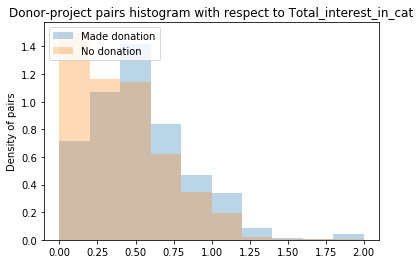

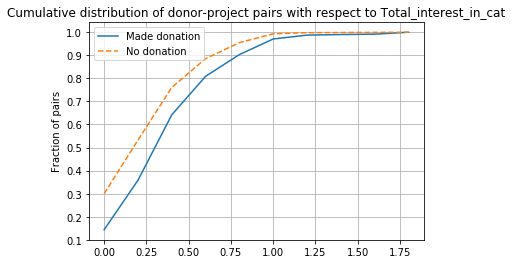

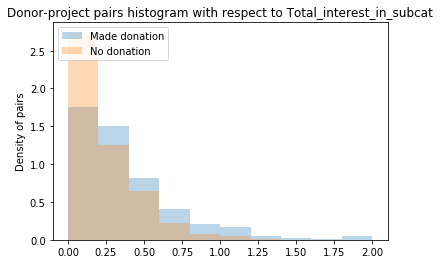

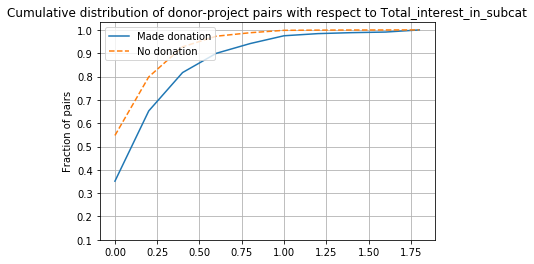

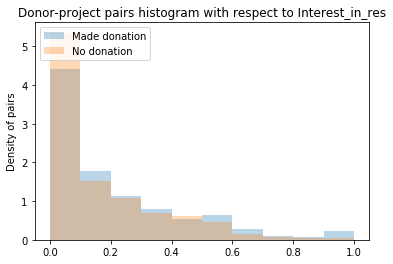

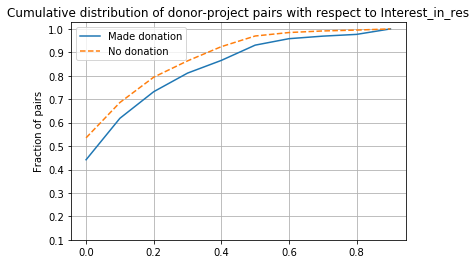

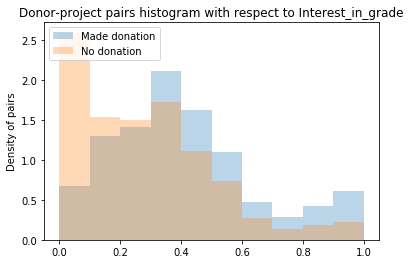

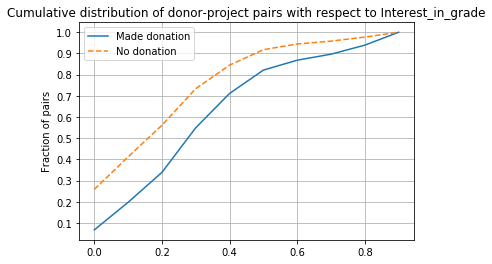

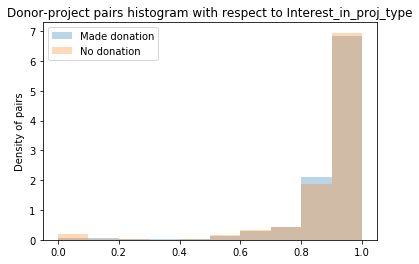

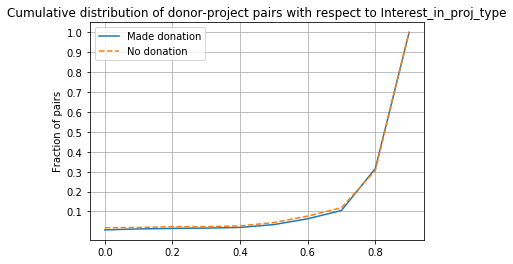

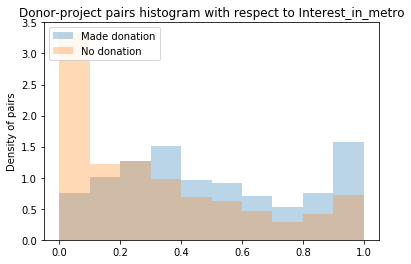

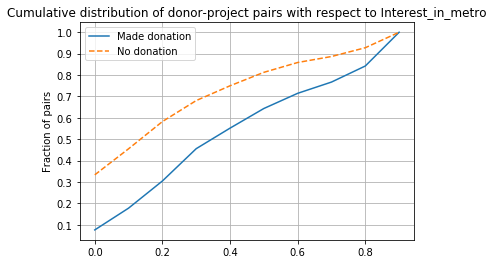

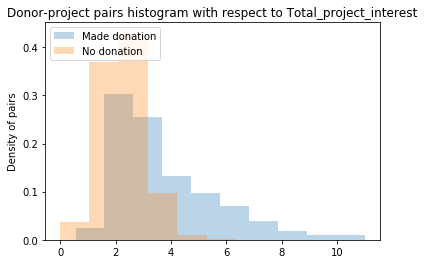

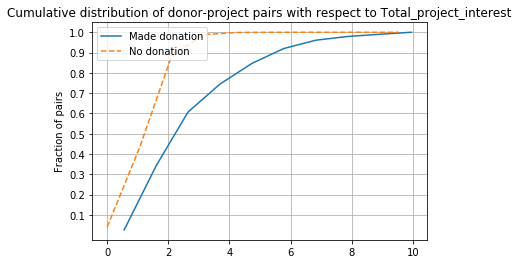

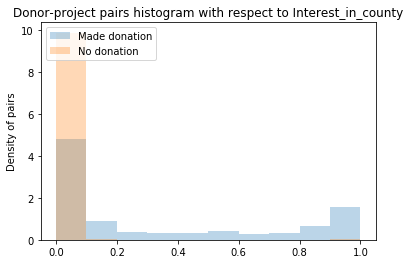

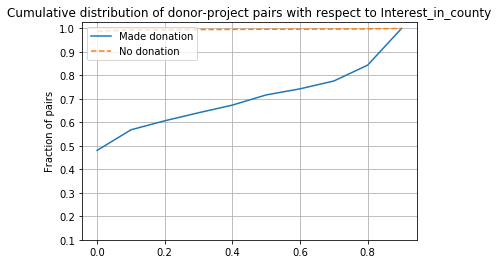

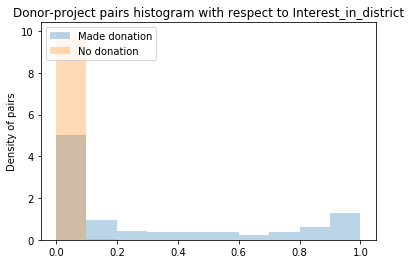

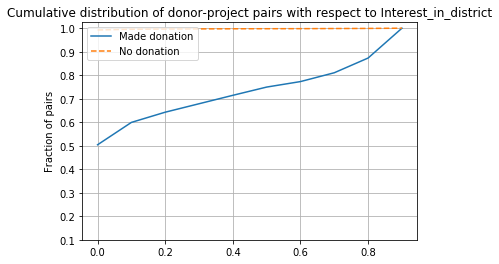

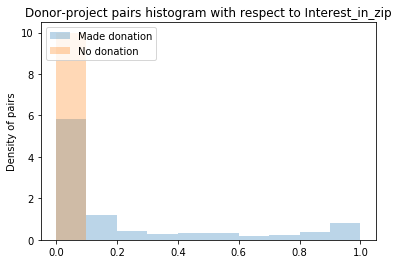

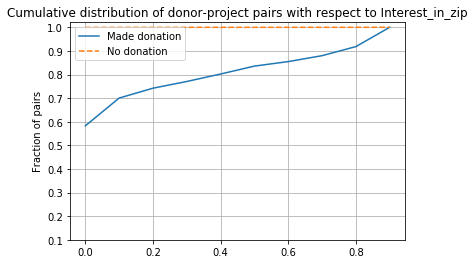

In [0]:
#Histograms and cumulative distribution graphs
NumBins = 10 #default 10

#Filter dataframe to get the desired columns
InterestVars = WholeTrainingSet[['Total_interest_in_cat', 'Total_interest_in_subcat', 'Interest_in_res', 'Interest_in_grade', 'Interest_in_proj_type',
                                'Interest_in_metro', 'Total_project_interest', 'Interest_in_county', 'Interest_in_district', 'Interest_in_zip',
                                'Donated_y_n']]

#Function to plot histogram and cumulative distribution
def HistAndCumuDist(df, ColName, NumBins):
    #Separate records with and without donations
    WithDonation = df[df['Donated_y_n'] == 'Y']
    NoDonation = df[df['Donated_y_n'] == 'N']
    
    #Format data for histogram
    values_WithD, base_WithD = np.histogram(WithDonation[ColName], bins=NumBins)
    values_NoD, base_NoD = np.histogram(NoDonation[ColName], bins=NumBins)
    
    #Format data for cumulative distribution, normalised
    CumuDist_WithD = np.cumsum(values_WithD) / WithDonation.shape[0]
    CumuDist_NoD = np.cumsum(values_NoD) / NoDonation.shape[0]
    
    #Plot the histogram
    fig, ax = plt.subplots()
    plt.hist(WithDonation[ColName], bins=base_WithD, alpha=0.3, label='Made donation', density=True)
    plt.hist(NoDonation[ColName], bins=base_NoD, alpha=0.3, label='No donation', density=True)
    plt.title('Donor-project pairs histogram with respect to ' + ColName)
    plt.ylabel('Density of pairs')
    plt.legend(loc='upper left')
    
    #Plot the cumulative function
    fig, ax = plt.subplots()
    plt.plot(base_WithD[:-1], CumuDist_WithD, label='Made donation')
    plt.plot(base_NoD[:-1], CumuDist_NoD, label='No donation', linestyle='dashed')
    plt.title('Cumulative distribution of donor-project pairs with respect to ' + ColName)
    plt.yticks((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
    plt.ylabel('Fraction of pairs')
    plt.legend(loc='upper left')
    ax.grid()
    
HistAndCumuDist(InterestVars, 'Total_interest_in_cat', NumBins)
HistAndCumuDist(InterestVars, 'Total_interest_in_subcat', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_res', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_grade', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_proj_type', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_metro', NumBins)
HistAndCumuDist(InterestVars, 'Total_project_interest', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_county', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_district', NumBins)
HistAndCumuDist(InterestVars, 'Interest_in_zip', NumBins)

In [0]:
data4[["Project Posted Date", "Project Fully Funded Date"]].isnull().sum()
## to see how many projects are still open, we may choose to remove that ones.

Project Posted Date               0
Project Fully Funded Date    437295
dtype: int64

In [0]:
# to understand their formats. These two columns are initially object types. We will convert them to datetime.
data4[["Project Fully Funded Date", "Project Posted Date"]].head(10)

,Project Fully Funded Date,Project Posted Date
0,2013-01-11,2013-01-01
1,2013-01-11,2013-01-01
2,2013-01-11,2013-01-01
3,2013-02-02,2013-01-08
4,2013-02-02,2013-01-08
5,2013-02-21,2013-02-04
6,2013-02-15,2013-02-11
7,2013-02-21,2013-02-17
8,2013-08-18,2013-08-01
9,2013-10-10,2013-08-12


In [0]:
#change to date type
data4["Project Posted Date"] = pd.to_datetime(data4["Project Posted Date"])
data4["Project Posted Date"].dtype
data4["Project Fully Funded Date"] = pd.to_datetime(data4["Project Fully Funded Date"].dropna())
data4["Project Fully Funded Date"].dtype

dtype('<M8[ns]')

In [0]:
#count number of days between the time when the project was funded and it got fully funded
data4["Funding Time"] = data4["Project Fully Funded Date"] - data4["Project Posted Date"]
data4[["Funding Time","Project Fully Funded Date","Project Posted Date"]].head()

,Funding Time,Project Fully Funded Date,Project Posted Date
0,10 days,2013-01-11,2013-01-01
1,10 days,2013-01-11,2013-01-01
2,10 days,2013-01-11,2013-01-01
3,25 days,2013-02-02,2013-01-08
4,25 days,2013-02-02,2013-01-08


In [0]:
data4[["Funding Time","Project Fully Funded Date","Project Posted Date"]].isnull().sum()

Funding Time                 437295
Project Fully Funded Date    437295
Project Posted Date               0
dtype: int64

In [0]:
data5 = data4[pd.notnull(data4["Funding Time"])]   ## to drop NaT values.
data5[["Funding Time","Project Fully Funded Date","Project Posted Date"]].isnull().sum()

Funding Time                 0
Project Fully Funded Date    0
Project Posted Date          0
dtype: int64

In [0]:
import datetime as dt
data5["Funding Time"] = data5["Funding Time"].dt.days 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
data5[["Funding Time","Project Fully Funded Date","Project Posted Date"]].head()

,Funding Time,Project Fully Funded Date,Project Posted Date
0,10,2013-01-11,2013-01-01
1,10,2013-01-11,2013-01-01
2,10,2013-01-11,2013-01-01
3,25,2013-02-02,2013-01-08
4,25,2013-02-02,2013-01-08


In [0]:
mean_time_project_funding = data5.groupby("Project ID")["Funding Time"].mean()
overall_mean_time = mean_time_project_funding.mean()
overall_mean_time

32.171606457403584

In [0]:
#Notice the fact that mean_time_project_funding is a series which consists of different mean funding times for different projects. 
#However, overall_mean_time is a value which gives us the mean funding time of all projects. 
#If we calculated overall_mean_time by simply using "Funding Time" column we would get the wrong answer since it basically duplicates 
#funding time column for each donation. Lets assert that :

In [0]:
wrong_overall_mean_time = data5["Funding Time"].mean()
wrong_overall_mean_time

35.47807690878336

In [0]:
#So we calculated that overall mean project fully funding time is approximately 32 days. 
#Lets dive deep to find whether this change significantly by different states.
states_project_funding_time = data5.groupby(["School State", "Project ID"])["Funding Time"].mean()
states_project_funding_time

School State  Project ID                      
Alabama       00002d44003ed46b066607c5455a999a     41
              000e336c167aae4394ac037e002aa2b9     58
              00105d1128dbbf4e0774804052b5bedb     27
              0014d0f8aa7dbbd5705956d7458a0d9f     15
              001a70c8fdb47880cbcde5675193b877     18
                                                 ... 
Wyoming       fe83942b407a1f868cb48b2bbeab4988     23
              febb789ba78badf633114020f1483392      2
              ff1d119bac584ec35d3740f83f3daa7d    112
              ff43f8665a9ed6a009f395b18d96734a     64
              ffbcf2e301bd4b2e80dc9faea5b02a57    110
Name: Funding Time, Length: 720847, dtype: int64

In [0]:
states_average_funding_time = states_project_funding_time.groupby("School State").mean()
states_average_funding_time.round(0)   ## to get the exact days I rounded to 0 decimal.

School State
Alabama                 36.0
Alaska                  34.0
Arizona                 35.0
Arkansas                35.0
California              32.0
Colorado                31.0
Connecticut             32.0
Delaware                33.0
District of Columbia    26.0
Florida                 31.0
Georgia                 35.0
Hawaii                  27.0
Idaho                   31.0
Illinois                30.0
Indiana                 32.0
Iowa                    37.0
Kansas                  31.0
Kentucky                33.0
Louisiana               36.0
Maine                   35.0
Maryland                32.0
Massachusetts           32.0
Michigan                32.0
Minnesota               31.0
Mississippi             37.0
Missouri                31.0
Montana                 31.0
Nebraska                36.0
Nevada                  35.0
New Hampshire           31.0
New Jersey              32.0
New Mexico              35.0
New York                33.0
North Carolina          32.0
N

In [0]:
#In the operations above, we calculated that average project fully funding time is 32 days. 
#Later we founded average project funding time for each states. Lets see which are them performing best (
# in which 10 states project funded earlier than average days ? ) 
#Lets also see which are them performing worst ( in which 10 states project funded later than average days ? )

In [0]:
ss = states_average_funding_time.round(0)
ss[ss < 32].sort_values().head(10)

School State
District of Columbia    26.0
Hawaii                  27.0
Wyoming                 29.0
Vermont                 30.0
Illinois                30.0
Oregon                  30.0
Pennsylvania            31.0
Oklahoma                31.0
New Hampshire           31.0
Colorado                31.0
Name: Funding Time, dtype: float64

Text(0.5, 1.0, 'States that fund projects faster than others')

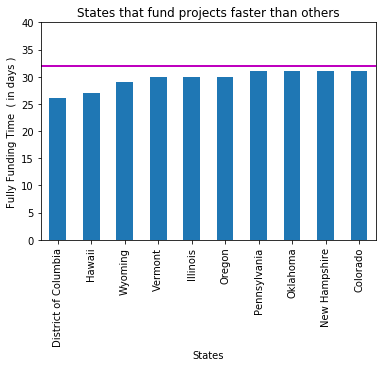

In [0]:
fast_funding_states = ss[ss < 32].sort_values().head(10)
fast_funding_states.plot.bar()
plt.axhline(32, color ="m", linewidth = 2)
plt.ylim(0,40)
plt.xlabel("States")
plt.ylabel("Fully Funding Time  ( in days )")
plt.title("States that fund projects faster than others")

In [0]:
ss[ss > 32].sort_values(ascending = False).head(10)

School State
Mississippi      37.0
Iowa             37.0
Nebraska         36.0
Louisiana        36.0
Utah             36.0
West Virginia    36.0
Alabama          36.0
North Dakota     35.0
New Mexico       35.0
Nevada           35.0
Name: Funding Time, dtype: float64

Text(0.5, 1.0, 'States that fund projects slower than others')

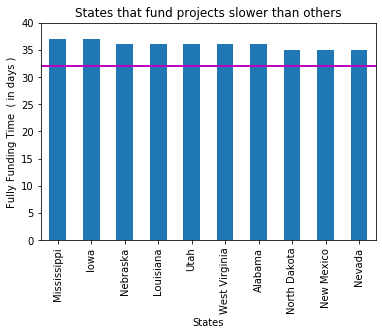

In [0]:
slow_funding_states = ss[ss > 32].sort_values(ascending = False).head(10)
slow_funding_states.plot.bar()
plt.axhline(32, color = "m", linewidth = 2)
plt.ylim(0,40)
plt.xlabel("States")
plt.ylabel("Fully Funding Time  ( in days )")
plt.title("States that fund projects slower than others")

In [0]:
#projects and population
#projetcs state revenue, donations and revenue